# **PROBLEMA DE NEGOCIO**


---


Una agencia inmobiliaria en California necesita mejorar su estrategia de precios para optimizar la compra y venta de propiedades. Actualmente, no se están considerando adecuadamente las variables espaciales, como la distancia a la costa y la proximidad a ciudades importantes, lo que afecta la rentabilidad. El objetivo del proyecto es desarrollar un modelo predictivo que, usando datos de geolocalización (latitud, longitud, distancia a la costa) y características del inmueble, permita estimar con precisión el precio de las viviendas y mejorar la toma de decisiones en su estrategia de precios.

### **Tus tareas principales serán:**

**1. Exploración de Datos:** Analizar y comprender el conjunto de datos proporcionado, identificar variables clave y realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes. Identificar tambien si la posicion geografica es determinante en el precio.

**2. Preprocesamiento de Datos:** Realizar limpieza de datos, limpiar valores atipicos y normalización/escalado de datos.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning xgboost, randomforest, lightbgm para predecir el valor medio de las viviendas.

**4. Evaluación y Selección del Modelo:**  Determinar el ajuste optimo del modelo por medio de `GridSearchCV` para tener predicciones que puedan ser empleadas como una herramienta de valorizacion de esos predios.

## **1. Configuración del Ambiente**


---

In [139]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.2/1.5 MB 2.6 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.5 MB 5.2 MB/s eta 0:00:01
   ------------------------------ --------- 1.1/1.5 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 7.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import os
from sklearn.preprocessing import RobustScaler

## **2. Exploración de Datos**


---

In [118]:
# Cargar dataset desde un archivo CSV (ajusta la ruta a tu archivo)
data = pd.read_csv('California_Houses.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Median_House_Value        20640 non-null  float64
 1   Median_Income             20640 non-null  float64
 2   Median_Age                20640 non-null  int64  
 3   Tot_Rooms                 20640 non-null  int64  
 4   Tot_Bedrooms              20640 non-null  int64  
 5   Population                20640 non-null  int64  
 6   Households                20640 non-null  int64  
 7   Latitude                  20640 non-null  float64
 8   Longitude                 20640 non-null  float64
 9   Distance_to_coast         20640 non-null  float64
 10  Distance_to_LA            20640 non-null  float64
 11  Distance_to_SanDiego      20640 non-null  float64
 12  Distance_to_SanJose       20640 non-null  float64
 13  Distance_to_SanFrancisco  20640 non-null  float64
dtypes: flo

In [119]:
data.describe()

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,2.064000e+04,2.064000e+04,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680,35.631861,-119.569704,40509.264883,2.694220e+05,3.981649e+05,349187.551219,386688.422291
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753,2.135952,2.003532,49140.039160,2.477324e+05,2.894006e+05,217149.875026,250122.192316
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000,120.676447,4.205891e+02,4.849180e+02,569.448118,456.141313
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000,33.930000,-121.800000,9079.756762,3.211125e+04,1.594264e+05,113119.928682,117395.477505
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000,34.260000,-118.490000,20522.019101,1.736675e+05,2.147398e+05,459758.877000,526546.661701
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000,37.710000,-118.010000,49830.414479,5.271562e+05,7.057954e+05,516946.490963,584552.007907
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000,333804.686371,1.018260e+06,1.196919e+06,836762.678210,903627.663298


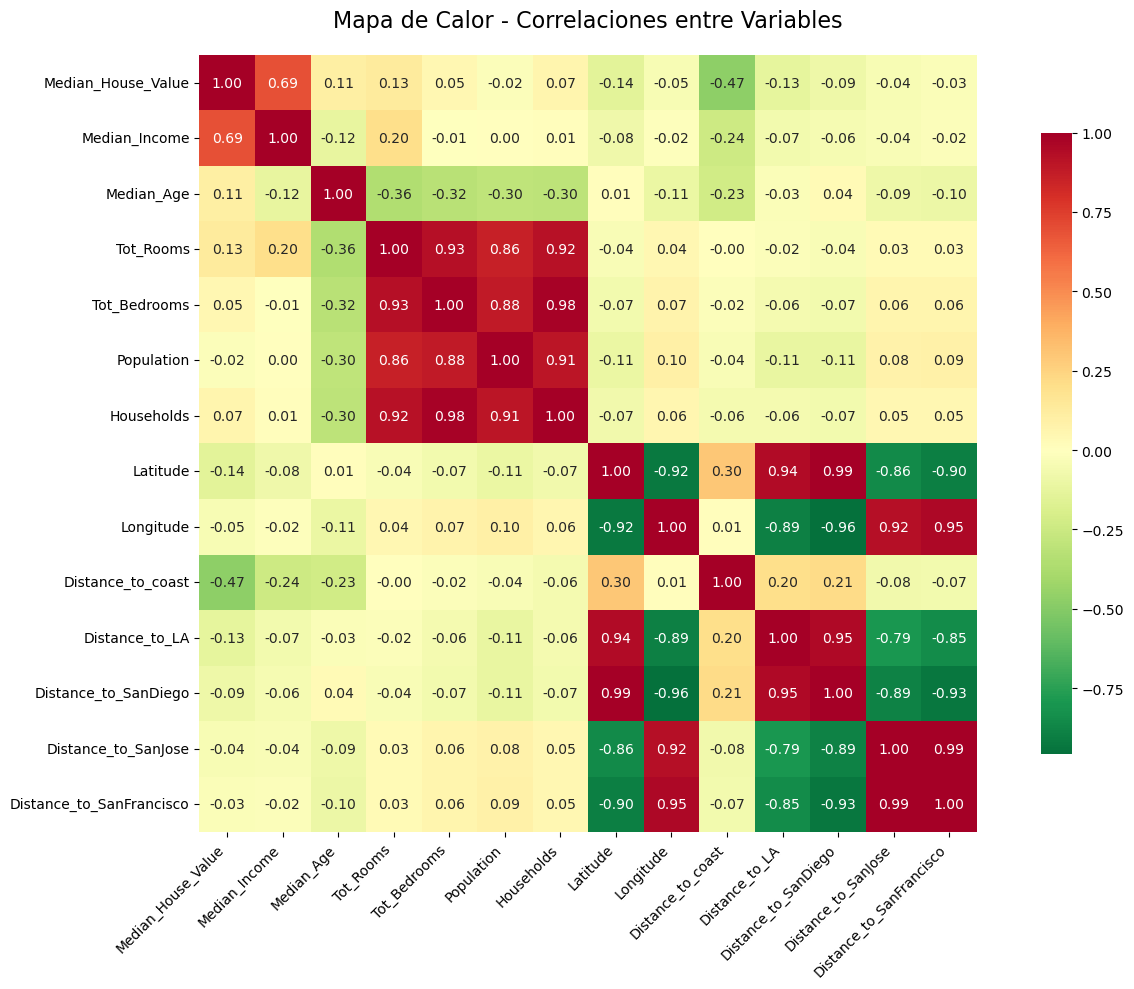

=== CORRELACIONES CON EL PRECIO DE VIVIENDA ===
Median_Income                 :  0.688
Tot_Rooms                     :  0.134
Median_Age                    :  0.106
Households                    :  0.066
Tot_Bedrooms                  :  0.051
Population                    : -0.025
Distance_to_SanFrancisco      : -0.031
Distance_to_SanJose           : -0.042
Longitude                     : -0.046
Distance_to_SanDiego          : -0.093
Distance_to_LA                : -0.131
Latitude                      : -0.144
Distance_to_coast             : -0.469


In [120]:
def visualize_correlations(data):
    """
    Crear mapa de calor de correlaciones
    """
    plt.figure(figsize=(14, 10))
    corr_matrix = data.corr()
    
    # Crear el mapa de calor con la paleta invertida
    palette = sns.color_palette("RdYlGn_r", as_cmap=True)
    
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap=palette, 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    
    plt.title('Mapa de Calor - Correlaciones entre Variables', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Mostrar correlaciones más fuertes con el precio
    target_corr = corr_matrix['Median_House_Value'].sort_values(ascending=False)
    print("=== CORRELACIONES CON EL PRECIO DE VIVIENDA ===")
    for var, corr in target_corr.items():
        if var != 'Median_House_Value':
            print(f"{var:30s}: {corr:6.3f}")

#Llamar función
visualize_correlations(data)

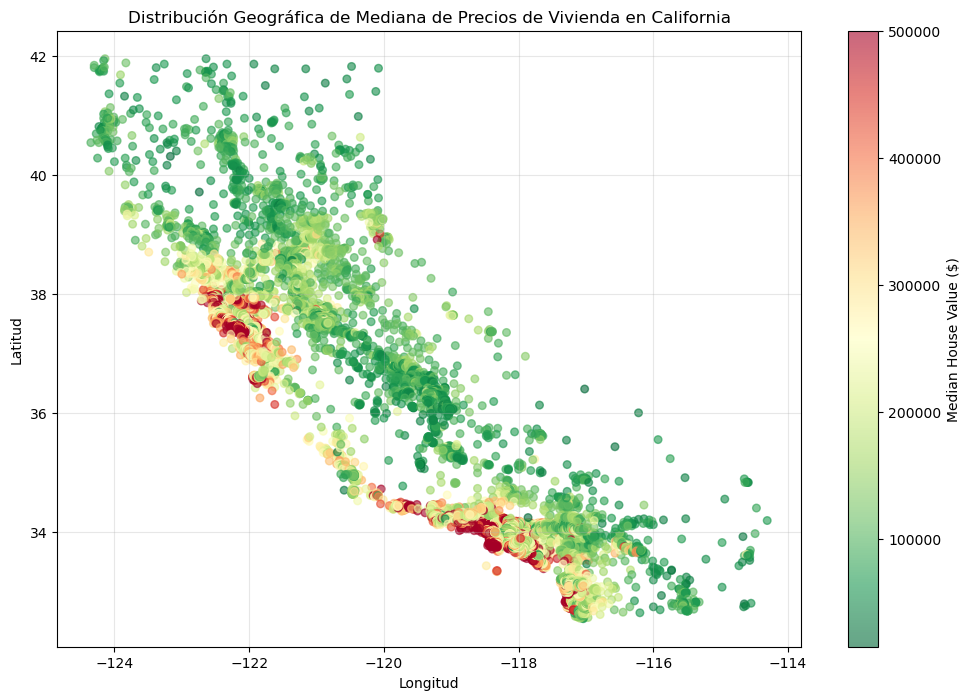

In [121]:
def plot_geographic_distribution(data):
    """
    Visualizar distribución geográfica de precios
    """
    plt.figure(figsize=(12, 8))
    
    # Crear el gráfico de dispersión con paleta invertida
    # RdYlGn_r: Rojo (valores altos) -> Amarillo -> Verde (valores bajos)
    scatter = plt.scatter(data['Longitude'], 
                         data['Latitude'], 
                         c=data['Median_House_Value'],
                         cmap='RdYlGn_r',  # Invertida: verde=bajo, rojo=alto
                         alpha=0.6,
                         s=30)
    
    plt.colorbar(scatter, label='Median House Value ($)')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Distribución Geográfica de Mediana de Precios de Vivienda en California')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_geographic_distribution(data)

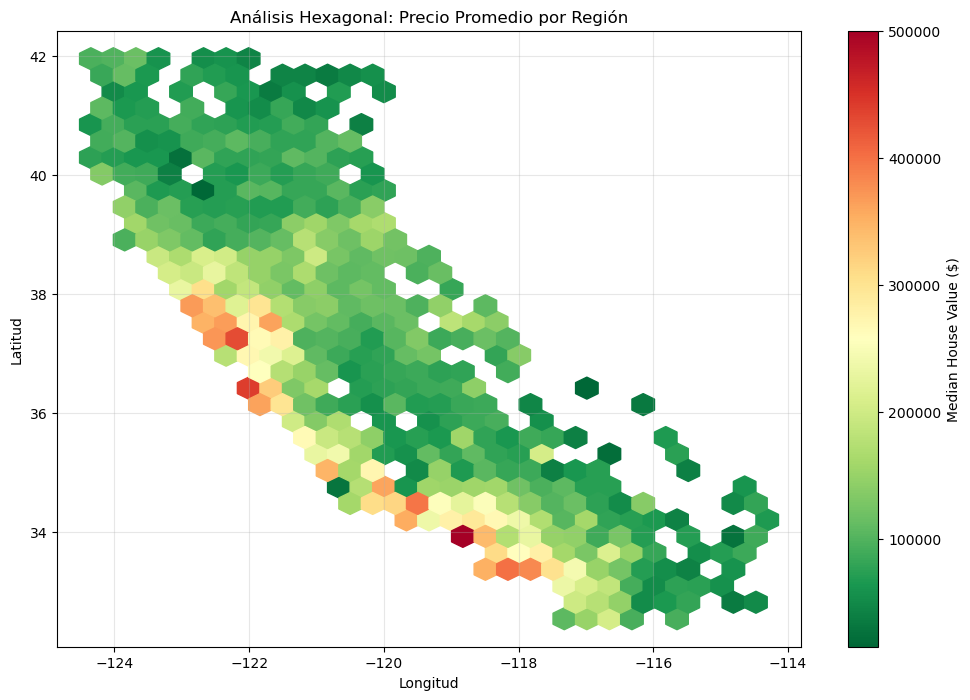

In [122]:
def plot_hexbin_analysis(data):
    """
    Análisis hexagonal de densidad y precios
    """
    plt.figure(figsize=(12, 8))
    
    # Crear el gráfico hexbin con promedio de precios
    hb = plt.hexbin(data['Longitude'], 
                    data['Latitude'],
                    C=data['Median_House_Value'],
                    gridsize=30,
                    cmap='RdYlGn_r',
                    reduce_C_function=np.mean)
    
    plt.colorbar(hb, label='Median House Value ($)')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Análisis Hexagonal: Precio Promedio por Región')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_hexbin_analysis(data)

In [123]:
def create_all_geographic_visualizations(data, output_folder="mapas_california"):
    """
    Crear todas las visualizaciones geográficas con Folium y guardarlas como archivos HTML
    """
    import os
    
    print("🗺️ CREANDO VISUALIZACIONES GEOGRÁFICAS CON FOLIUM...")
    print(f"📋 Columnas disponibles en el dataset: {list(data.columns)}")
    
    # Crear carpeta de salida si no existe
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"📁 Carpeta '{output_folder}' creada")
    
    results = {}
    
    try:
        # Detectar automáticamente las columnas de coordenadas
        lat_col, lon_col = detect_coordinate_columns(data)
        
        if not lat_col or not lon_col:
            print("⚠️ No se pudieron detectar columnas de coordenadas válidas")
            print("💡 Las columnas deben contener valores numéricos de latitud y longitud")
            return {'error': 'No se encontraron columnas de coordenadas válidas'}
        
        print(f"✅ Usando columnas: latitud='{lat_col}', longitud='{lon_col}'")
        
        # 1. Mapa básico con marcadores
        print("\n1. Creando mapa básico con marcadores...")
        basic_map = create_basic_folium_map(data, lat_col, lon_col)
        basic_file = os.path.join(output_folder, "01_mapa_basico.html")
        basic_map.save(basic_file)
        print(f"   ✅ Guardado: {basic_file}")
        results['basic_map'] = basic_file
        
        # 2. Mapa de calor con Folium
        print("\n2. Creando mapa de calor...")
        heatmap = create_folium_heatmap(data, lat_col, lon_col)
        heatmap_file = os.path.join(output_folder, "02_mapa_calor.html")
        heatmap.save(heatmap_file)
        print(f"   ✅ Guardado: {heatmap_file}")
        results['heatmap'] = heatmap_file
        
        # 3. Mapa con clusters
        print("\n3. Creando mapa con clusters...")
        cluster_map = create_folium_cluster_map(data, lat_col, lon_col)
        cluster_file = os.path.join(output_folder, "03_mapa_clusters.html")
        cluster_map.save(cluster_file)
        print(f"   ✅ Guardado: {cluster_file}")
        results['cluster_map'] = cluster_file
        
        # 4. Mapa con segmentación por precio
        print("\n4. Creando mapa segmentado por precios...")
        price_segment_map = create_folium_price_segments(data, lat_col, lon_col)
        segment_file = os.path.join(output_folder, "04_mapa_segmentos_precio.html")
        price_segment_map.save(segment_file)
        print(f"   ✅ Guardado: {segment_file}")
        results['price_segment_map'] = segment_file
        
        print(f"\n🎉 ¡TODAS LAS VISUALIZACIONES COMPLETADAS!")
        print(f"📁 Archivos guardados en la carpeta: '{output_folder}'")
        print(f"📊 4 mapas HTML creados exitosamente")
        
        # Crear archivo índice
        create_index_html(output_folder, results)
        
        return results
        
    except Exception as e:
        print(f"❌ Error general en la creación de visualizaciones: {e}")
        return {'error': str(e)}

def create_index_html(output_folder, results):
    """
    Crear un archivo índice HTML que liste todos los mapas
    """
    index_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Mapas de California Housing Dataset</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 40px; background-color: #f5f5f5; }
            .container { max-width: 800px; margin: 0 auto; background: white; padding: 30px; border-radius: 10px; box-shadow: 0 0 10px rgba(0,0,0,0.1); }
            h1 { color: #2c3e50; text-align: center; margin-bottom: 30px; }
            .map-card { background: #f8f9fa; padding: 20px; margin: 15px 0; border-radius: 8px; border-left: 4px solid #3498db; }
            .map-card h3 { color: #2c3e50; margin-top: 0; }
            .map-card p { color: #666; margin: 10px 0; }
            .map-link { display: inline-block; padding: 10px 20px; background: #3498db; color: white; text-decoration: none; border-radius: 5px; transition: background 0.3s; }
            .map-link:hover { background: #2980b9; }
            .info { background: #e8f5e8; padding: 15px; border-radius: 5px; margin: 20px 0; }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>🗺️ Mapas Interactivos - California Housing Dataset</h1>
            
            <div class="info">
                <strong>📋 Información:</strong> Esta visualización incluye 4 mapas interactivos creados con Folium 
                para analizar el dataset de viviendas de California. Cada mapa ofrece una perspectiva diferente de los datos.
            </div>
            
            <div class="map-card">
                <h3>🏠 1. Mapa Básico</h3>
                <p>Marcadores individuales con información detallada de cada casa (muestra de 100 propiedades).</p>
                <a href="01_mapa_basico.html" class="map-link" target="_blank">Ver Mapa Básico</a>
            </div>
            
            <div class="map-card">
                <h3>🔥 2. Mapa de Calor</h3>
                <p>Visualización de densidad de precios de viviendas en California usando gradiente de colores.</p>
                <a href="02_mapa_calor.html" class="map-link" target="_blank">Ver Mapa de Calor</a>
            </div>
            
            <div class="map-card">
                <h3>📍 3. Mapa con Clusters</h3>
                <p>Agrupación inteligente de marcadores por ubicación geográfica (muestra de 500 propiedades).</p>
                <a href="03_mapa_clusters.html" class="map-link" target="_blank">Ver Mapa de Clusters</a>
            </div>
            
            <div class="map-card">
                <h3>💰 4. Mapa de Segmentos de Precio</h3>
                <p>Propiedades categorizadas por rangos de precio con código de colores (muestra de 300 propiedades).</p>
                <a href="04_mapa_segmentos_precio.html" class="map-link" target="_blank">Ver Mapa de Segmentos</a>
            </div>
            
            <div class="info">
                <strong>💡 Tip:</strong> Haz clic en los marcadores para ver información detallada. 
                Usa los controles de zoom y las capas disponibles para explorar los datos.
            </div>
        </div>
    </body>
    </html>
    """
    
    index_file = os.path.join(output_folder, "index.html")
    with open(index_file, 'w', encoding='utf-8') as f:
        f.write(index_content)
    
    print(f"📄 Archivo índice creado: {index_file}")
    print(f"🌐 Abre 'index.html' en tu navegador para ver todos los mapas")

def detect_coordinate_columns(data):
    """
    Detectar automáticamente las columnas de latitud y longitud
    """
    lat_col = None
    lon_col = None
    
    # Posibles nombres para latitud (incluir variaciones con mayúsculas)
    lat_names = ['lat', 'latitude', 'latitud', 'y', 'coord_y', 'lat_coord']
    # Posibles nombres para longitud  
    lon_names = ['lon', 'lng', 'longitude', 'longitud', 'x', 'coord_x', 'lon_coord']
    
    # Buscar columnas de latitud (comparar en minúsculas)
    for col in data.columns:
        if col.lower() in lat_names:
            # Verificar que contenga valores numéricos válidos para latitud (-90 a 90)
            if data[col].dtype in ['float64', 'int64'] and data[col].between(-90, 90).any():
                lat_col = col
                break
    
    # Buscar columnas de longitud (comparar en minúsculas)
    for col in data.columns:
        if col.lower() in lon_names:
            # Verificar que contenga valores numéricos válidos para longitud (-180 a 180)
            if data[col].dtype in ['float64', 'int64'] and data[col].between(-180, 180).any():
                lon_col = col
                break
    
    # Si no encuentra por nombre, buscar por rangos de valores
    if not lat_col or not lon_col:
        numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
        
        for col in numeric_cols:
            values = data[col].dropna()
            if len(values) > 0:
                # Detectar latitud por rango (valores entre 32-42 para California)
                if not lat_col and values.between(32, 42).all() and (values.std() > 0.001):
                    lat_col = col
                # Detectar longitud por rango (valores entre -125 a -114 para California)
                elif not lon_col and values.between(-125, -114).all() and (values.std() > 0.001):
                    lon_col = col
    
    return lat_col, lon_col

def create_basic_folium_map(data, lat_col, lon_col):
    """
    Crear mapa básico con marcadores - TODOS los puntos
    """
    import folium
    
    # Calcular centro del mapa
    center_lat = data[lat_col].mean()
    center_lon = data[lon_col].mean()
    
    # Crear mapa base con mejor zoom inicial
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=6,  # Zoom más amplio para ver toda California
        tiles='OpenStreetMap'
    )
    
    # Buscar columna de precio
    price_col = None
    for col_name in ['Median_House_Value', 'price', 'precio', 'valor', 'cost', 'costo']:
        if col_name in data.columns:
            price_col = col_name
            break
    
    print(f"   📍 Agregando {len(data)} marcadores al mapa básico...")
    
    # Agregar TODOS los marcadores (sin límite)
    for idx, row in data.iterrows():
        # Verificar que las coordenadas sean válidas
        if pd.notna(row[lat_col]) and pd.notna(row[lon_col]):
            price_value = row.get(price_col) if price_col else None
            
            # Formatear valores de manera segura
            price_text = f"${price_value:,.0f}" if pd.notna(price_value) else "N/A"
            income_value = row.get('Median_Income')
            income_text = f"${income_value:,.0f}" if pd.notna(income_value) else "N/A"
            population_value = row.get('Population')
            population_text = f"{population_value:,.0f}" if pd.notna(population_value) else "N/A"
            age_value = row.get('Median_Age')
            age_text = f"{age_value}" if pd.notna(age_value) else "N/A"
            rooms_value = row.get('Tot_Rooms')
            rooms_text = f"{rooms_value:,.0f}" if pd.notna(rooms_value) else "N/A"
            
            popup_text = f"""
            <b>Casa #{idx}</b><br>
            <b>Valor Mediano:</b> {price_text}<br>
            <b>Ingreso Mediano:</b> {income_text}<br>
            <b>Edad Mediana:</b> {age_text} años<br>
            <b>Población:</b> {population_text}<br>
            <b>Total Habitaciones:</b> {rooms_text}<br>
            <b>Coordenadas:</b> ({row[lat_col]:.4f}, {row[lon_col]:.4f})
            """
            
            # Usar CircleMarker en lugar de Marker para mejor rendimiento con muchos puntos
            folium.CircleMarker(
                location=[row[lat_col], row[lon_col]],
                radius=3,  # Puntos pequeños
                popup=folium.Popup(popup_text, max_width=350),
                tooltip=f"Casa #{idx} - {price_text}",
                color='blue',
                fill=True,
                fillColor='blue',
                fillOpacity=0.7,
                weight=1
            ).add_to(m)
    
    # Agregar información del mapa
    title_html = '''
    <h3 align="center" style="font-size:16px"><b>Mapa Básico - California Housing Dataset</b></h3>
    <p align="center">Todos los puntos del dataset ({} casas)</p>
    '''.format(len(data))
    m.get_root().html.add_child(folium.Element(title_html))
    
    print(f"   ✅ {len(data)} marcadores agregados exitosamente")
    return m

def create_folium_heatmap(data, lat_col, lon_col):
    """
    Crear mapa de calor con Folium
    """
    import folium
    from folium.plugins import HeatMap
    
    # Calcular centro
    center_lat = data[lat_col].mean()
    center_lon = data[lon_col].mean()
    
    # Crear mapa base
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=9,
        tiles='OpenStreetMap'
    )
    
    # Buscar columna de precio con diferentes nombres
    price_col = None
    for col_name in ['Median_House_Value', 'price', 'precio', 'valor', 'cost', 'costo']:
        if col_name in data.columns:
            price_col = col_name
            break
    
    # Preparar datos para el mapa de calor
    # Si existe columna de precio, usar como peso
    if price_col:
        # Normalizar los valores de precio para el mapa de calor
        max_price = data[price_col].max()
        heat_data = [[row[lat_col], row[lon_col], row[price_col]/max_price] 
                    for idx, row in data.iterrows() 
                    if pd.notna(row[lat_col]) and pd.notna(row[lon_col]) and pd.notna(row[price_col])]
    else:
        heat_data = [[row[lat_col], row[lon_col]] 
                    for idx, row in data.iterrows() 
                    if pd.notna(row[lat_col]) and pd.notna(row[lon_col])]
    
    # Agregar capa de calor
    HeatMap(
        heat_data,
        min_opacity=0.2,
        max_zoom=18,
        radius=15,
        blur=10,
        gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'}
    ).add_to(m)
    
    return m

def create_folium_cluster_map(data, lat_col, lon_col):
    """
    Crear mapa con clusters de marcadores
    """
    import folium
    from folium.plugins import MarkerCluster
    
    # Calcular centro
    center_lat = data[lat_col].mean()
    center_lon = data[lon_col].mean()
    
    # Crear mapa base
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=9,
        tiles='OpenStreetMap'
    )
    
    # Crear cluster de marcadores
    marker_cluster = MarkerCluster(
        name="Casas",
        overlay=True,
    ).add_to(m)
    
    # Buscar columna de precio
    price_col = None
    for col_name in ['Median_House_Value', 'price', 'precio', 'valor', 'cost', 'costo']:
        if col_name in data.columns:
            price_col = col_name
            break
    
    # Agregar marcadores al cluster (limitar para rendimiento)
    sample_data = data.sample(n=min(500, len(data))) if len(data) > 500 else data
    
    for idx, row in sample_data.iterrows():
        if pd.notna(row[lat_col]) and pd.notna(row[lon_col]):
            price_value = row.get(price_col) if price_col else None
            income_value = row.get('Median_Income')
            population_value = row.get('Population')
            
            # Formatear valores de manera segura
            price_text = f"${price_value:,.0f}" if pd.notna(price_value) else "N/A"
            income_text = f"${income_value:,.0f}" if pd.notna(income_value) else "N/A"
            population_text = f"{population_value:,.0f}" if pd.notna(population_value) else "N/A"
            
            popup_text = f"""
            <b>Casa #{idx}</b><br>
            Valor Mediano: {price_text}<br>
            Ingreso Mediano: {income_text}<br>
            Población: {population_text}
            """
            
            folium.Marker(
                location=[row[lat_col], row[lon_col]],
                popup=folium.Popup(popup_text, max_width=300),
                tooltip=f"Casa #{idx}"
            ).add_to(marker_cluster)
    
    # Agregar control de capas
    folium.LayerControl().add_to(m)
    
    return m

def create_folium_price_segments(data, lat_col, lon_col):
    """
    Crear mapa segmentado por rangos de precio
    """
    import folium
    import numpy as np
    
    # Buscar columna de precio
    price_col = None
    for col_name in ['Median_House_Value', 'price', 'precio', 'valor', 'cost', 'costo']:
        if col_name in data.columns:
            price_col = col_name
            break
    
    # Si no hay columna de precio, crear mapa básico
    if not price_col:
        print("⚠️ No se encontró columna de precio para segmentación")
        return create_basic_folium_map(data, lat_col, lon_col)
    
    # Calcular centro
    center_lat = data[lat_col].mean()
    center_lon = data[lon_col].mean()
    
    # Crear mapa base
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=9,
        tiles='OpenStreetMap'
    )
    
    # Definir rangos de precio
    prices = data[price_col].dropna()
    if len(prices) == 0:
        return create_basic_folium_map(data, lat_col, lon_col)
    
    q25 = prices.quantile(0.25)
    q50 = prices.quantile(0.50)
    q75 = prices.quantile(0.75)
    
    # Definir colores y etiquetas para cada segmento
    def get_price_segment(price):
        if pd.isna(price):
            return 'Sin precio', 'gray'
        elif price <= q25:
            return 'Económico', 'green'
        elif price <= q50:
            return 'Medio-Bajo', 'blue'
        elif price <= q75:
            return 'Medio-Alto', 'orange'
        else:
            return 'Premium', 'red'
    
    # Agregar marcadores por segmento (muestra aleatoria para rendimiento)
    sample_data = data.sample(n=min(300, len(data))) if len(data) > 300 else data
    
    for idx, row in sample_data.iterrows():
        if pd.notna(row[lat_col]) and pd.notna(row[lon_col]):
            price = row.get(price_col)
            segment, color = get_price_segment(price)
            
            # Formatear valores de manera segura
            price_text = f"${price:,.0f}" if pd.notna(price) else "N/A"
            income_value = row.get('Median_Income')
            income_text = f"${income_value:,.0f}" if pd.notna(income_value) else "N/A"
            age_value = row.get('Median_Age')
            age_text = f"{age_value}" if pd.notna(age_value) else "N/A"
            
            popup_text = f"""
            <b>Casa #{idx}</b><br>
            <b>Segmento: {segment}</b><br>
            Valor Mediano: {price_text}<br>
            Ingreso Mediano: {income_text}<br>
            Edad Mediana: {age_text} años
            """
            
            tooltip_text = f"{segment} - {price_text}"
            
            folium.Marker(
                location=[row[lat_col], row[lon_col]],
                popup=folium.Popup(popup_text, max_width=300),
                tooltip=tooltip_text,
                icon=folium.Icon(color=color, icon='home')
            ).add_to(m)
    
    # Agregar leyenda personalizada
    legend_html = f'''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 180px; height: 140px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <b>Segmentos de Precio de Casas</b><br>
    <i class="fa fa-circle" style="color:green"></i> Económico (≤${q25:,.0f})<br>
    <i class="fa fa-circle" style="color:blue"></i> Medio-Bajo (≤${q50:,.0f})<br>
    <i class="fa fa-circle" style="color:orange"></i> Medio-Alto (≤${q75:,.0f})<br>
    <i class="fa fa-circle" style="color:red"></i> Premium (>${q75:,.0f})<br>
    <small>Muestra de {len(sample_data)} casas</small>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Ejecutar la función para crear y guardar todos los mapas
results = create_all_geographic_visualizations(data)

# Los archivos se guardarán automáticamente como:
# - mapas_california/01_mapa_basico.html
# - mapas_california/02_mapa_calor.html  
# - mapas_california/03_mapa_clusters.html
# - mapas_california/04_mapa_segmentos_precio.html
# - mapas_california/index.html (página principal con enlaces)


🗺️ CREANDO VISUALIZACIONES GEOGRÁFICAS CON FOLIUM...
📋 Columnas disponibles en el dataset: ['Median_House_Value', 'Median_Income', 'Median_Age', 'Tot_Rooms', 'Tot_Bedrooms', 'Population', 'Households', 'Latitude', 'Longitude', 'Distance_to_coast', 'Distance_to_LA', 'Distance_to_SanDiego', 'Distance_to_SanJose', 'Distance_to_SanFrancisco']
✅ Usando columnas: latitud='Latitude', longitud='Longitude'

1. Creando mapa básico con marcadores...
   📍 Agregando 20640 marcadores al mapa básico...
   ✅ 20640 marcadores agregados exitosamente
   ✅ Guardado: mapas_california\01_mapa_basico.html

2. Creando mapa de calor...
   ✅ Guardado: mapas_california\02_mapa_calor.html

3. Creando mapa con clusters...
   ✅ Guardado: mapas_california\03_mapa_clusters.html

4. Creando mapa segmentado por precios...
   ✅ Guardado: mapas_california\04_mapa_segmentos_precio.html

🎉 ¡TODAS LAS VISUALIZACIONES COMPLETADAS!
📁 Archivos guardados en la carpeta: 'mapas_california'
📊 4 mapas HTML creados exitosamente
📄 Ar

## **3. Preprocesamiento de Datos**


---

### 3.1 Evaluando Outliers

📊 Creando histogramas para 14 variable(s)...


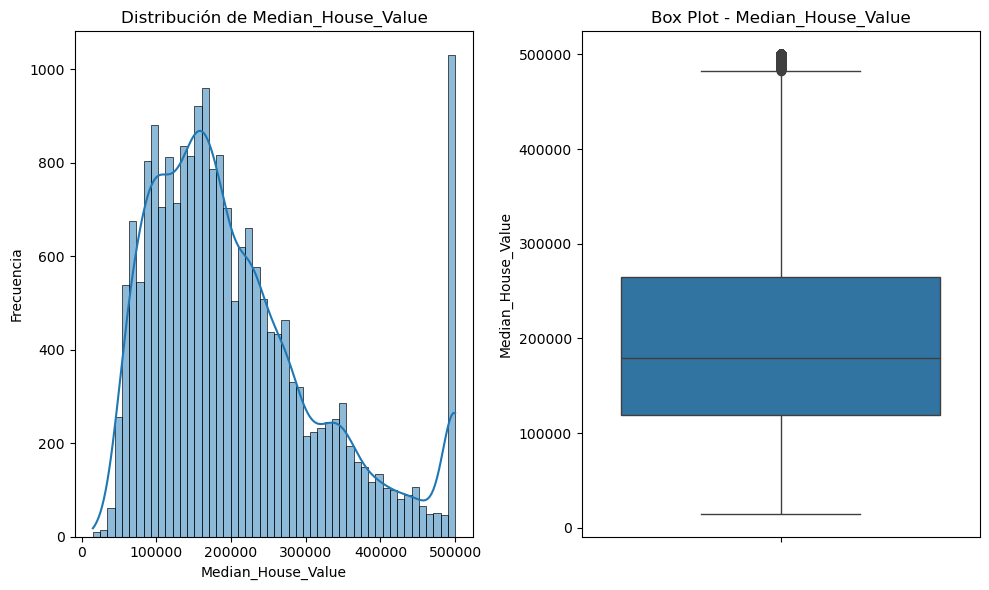


=== ESTADÍSTICAS DE Median_House_Value ===
Media: 206855.82
Mediana: 179700.00
Desviación estándar: 115395.62
Valores únicos: 3842
Valores nulos: 0
--------------------------------------------------


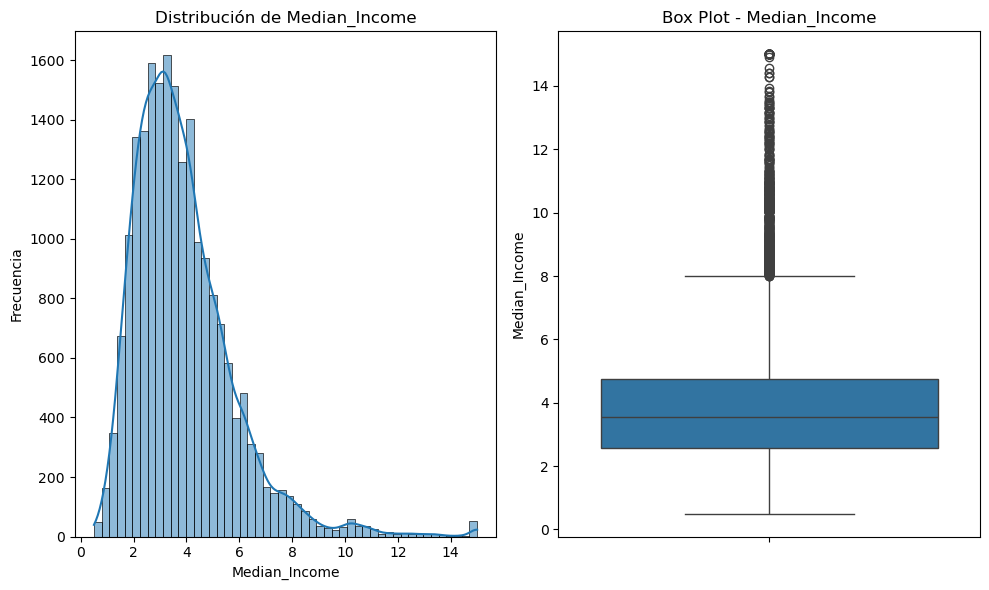


=== ESTADÍSTICAS DE Median_Income ===
Media: 3.87
Mediana: 3.53
Desviación estándar: 1.90
Valores únicos: 12928
Valores nulos: 0
--------------------------------------------------


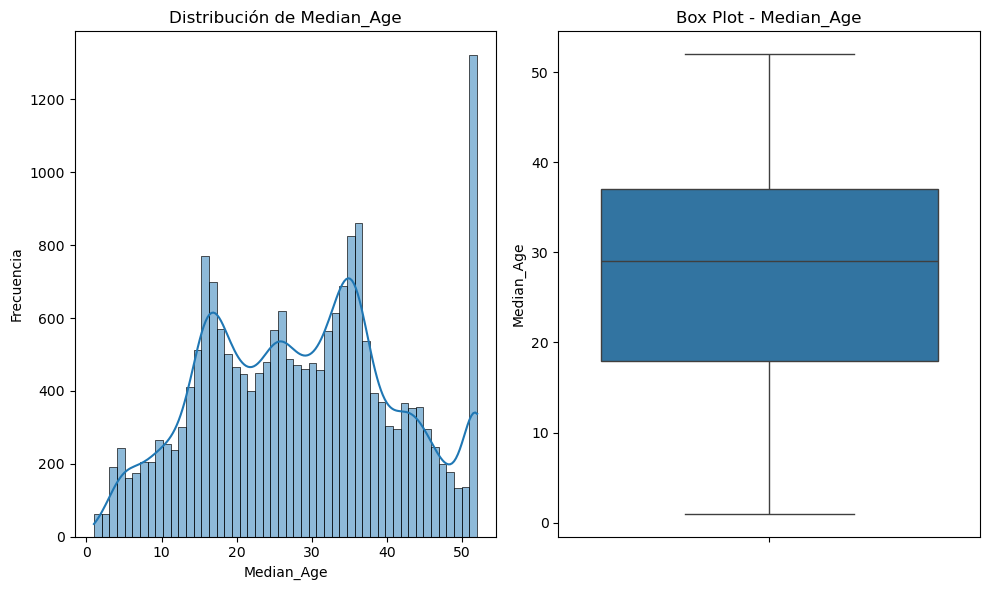


=== ESTADÍSTICAS DE Median_Age ===
Media: 28.64
Mediana: 29.00
Desviación estándar: 12.59
Valores únicos: 52
Valores nulos: 0
--------------------------------------------------


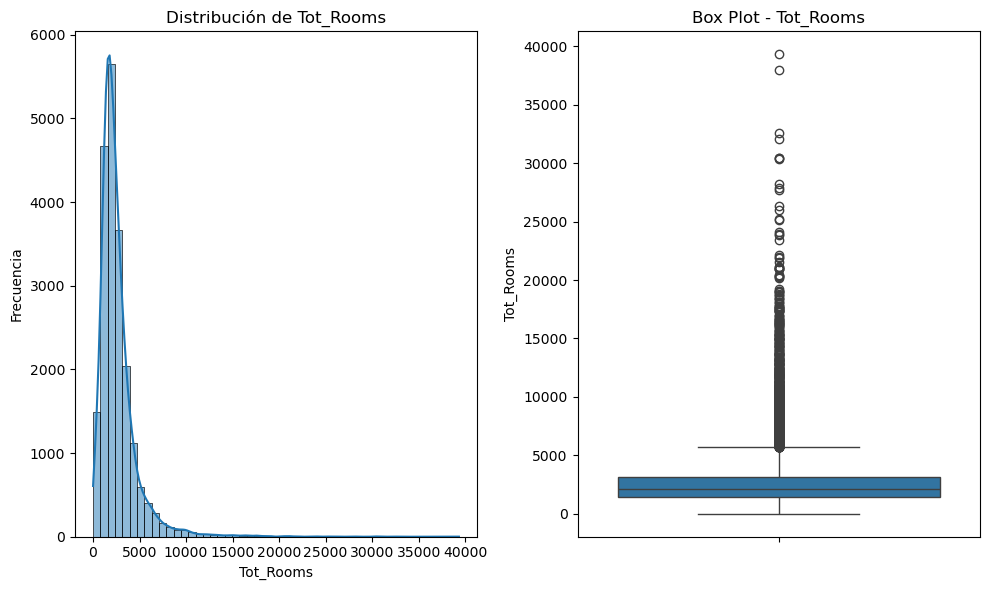


=== ESTADÍSTICAS DE Tot_Rooms ===
Media: 2635.76
Mediana: 2127.00
Desviación estándar: 2181.62
Valores únicos: 5926
Valores nulos: 0
--------------------------------------------------


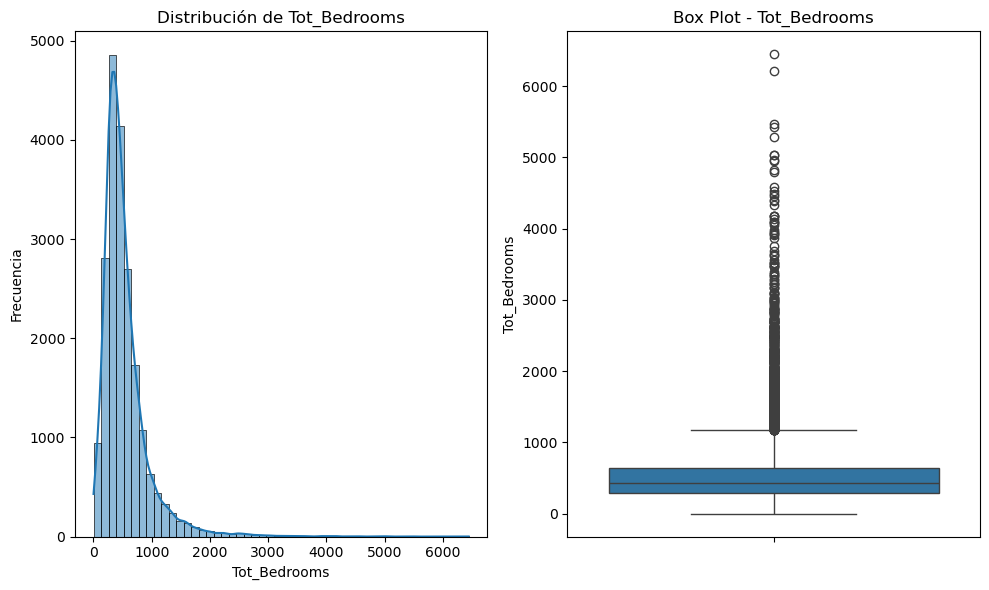


=== ESTADÍSTICAS DE Tot_Bedrooms ===
Media: 537.90
Mediana: 435.00
Desviación estándar: 421.25
Valores únicos: 1928
Valores nulos: 0
--------------------------------------------------


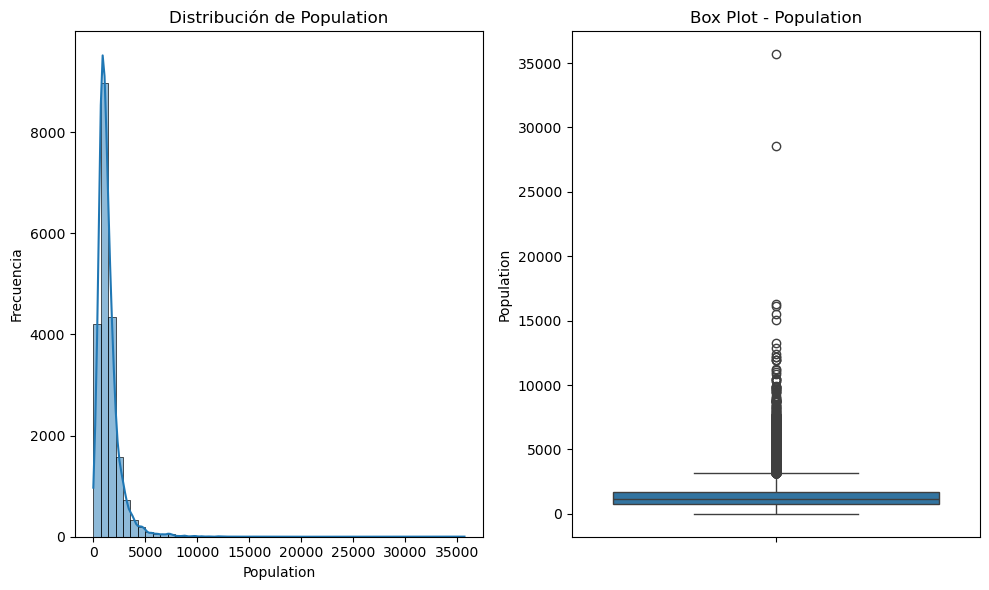


=== ESTADÍSTICAS DE Population ===
Media: 1425.48
Mediana: 1166.00
Desviación estándar: 1132.46
Valores únicos: 3888
Valores nulos: 0
--------------------------------------------------


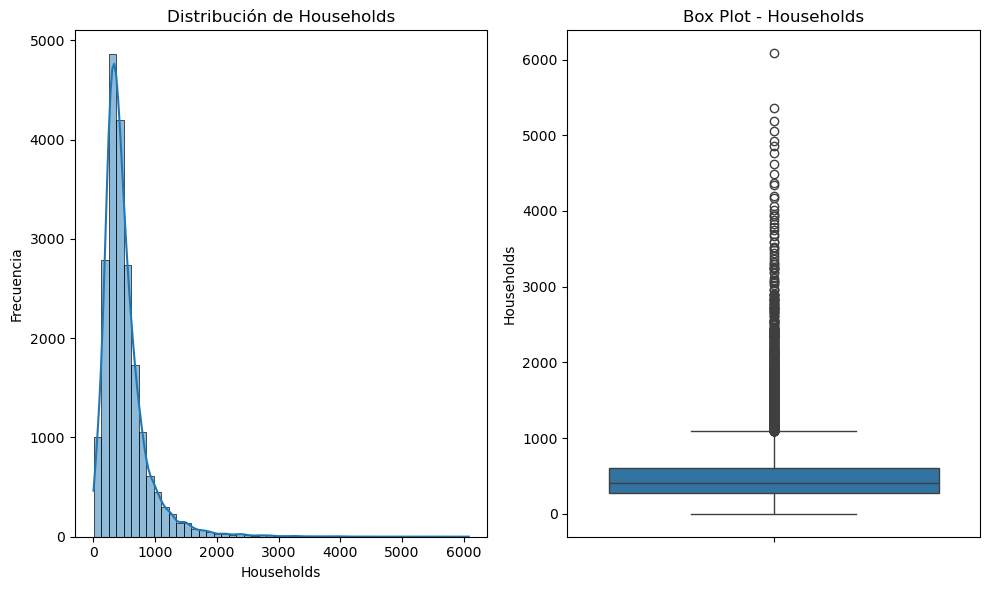


=== ESTADÍSTICAS DE Households ===
Media: 499.54
Mediana: 409.00
Desviación estándar: 382.33
Valores únicos: 1815
Valores nulos: 0
--------------------------------------------------


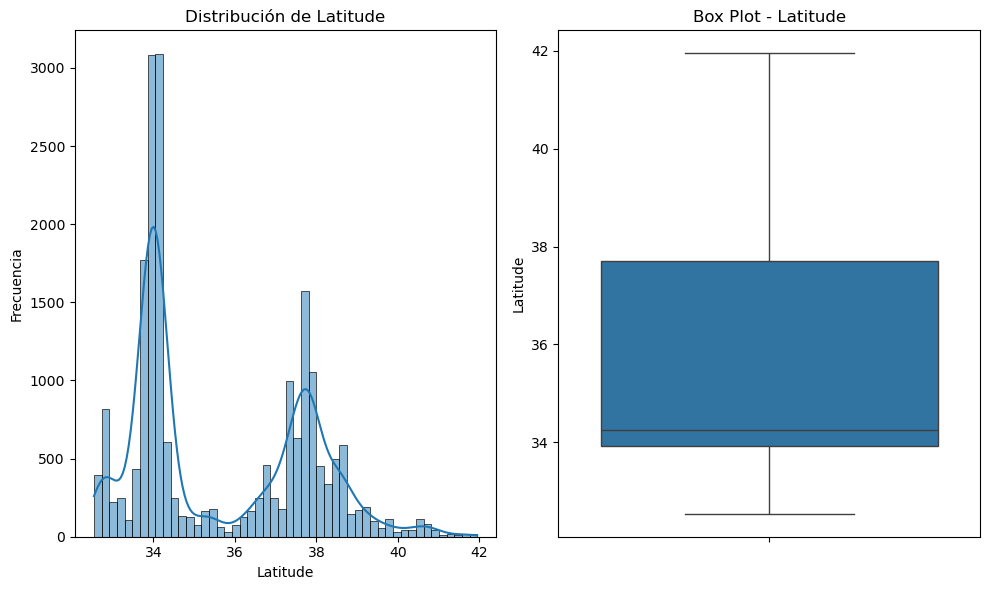


=== ESTADÍSTICAS DE Latitude ===
Media: 35.63
Mediana: 34.26
Desviación estándar: 2.14
Valores únicos: 862
Valores nulos: 0
--------------------------------------------------


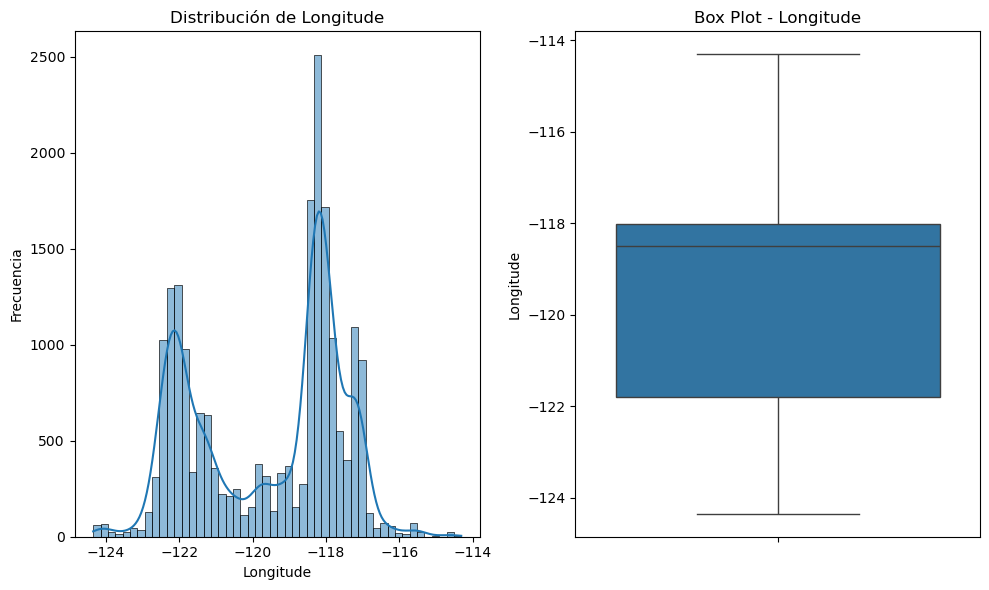


=== ESTADÍSTICAS DE Longitude ===
Media: -119.57
Mediana: -118.49
Desviación estándar: 2.00
Valores únicos: 844
Valores nulos: 0
--------------------------------------------------


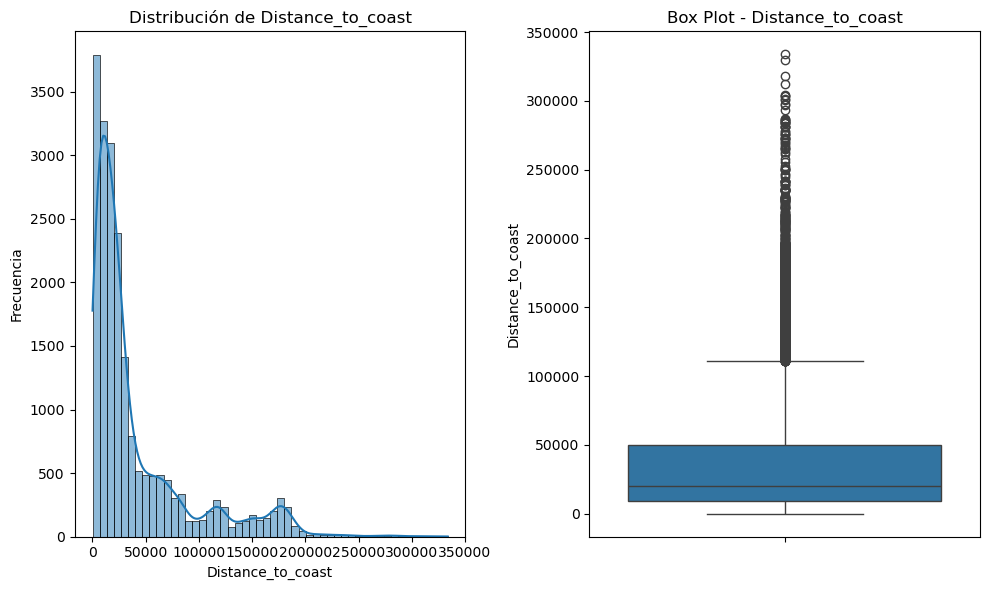


=== ESTADÍSTICAS DE Distance_to_coast ===
Media: 40509.26
Mediana: 20522.02
Desviación estándar: 49140.04
Valores únicos: 12590
Valores nulos: 0
--------------------------------------------------


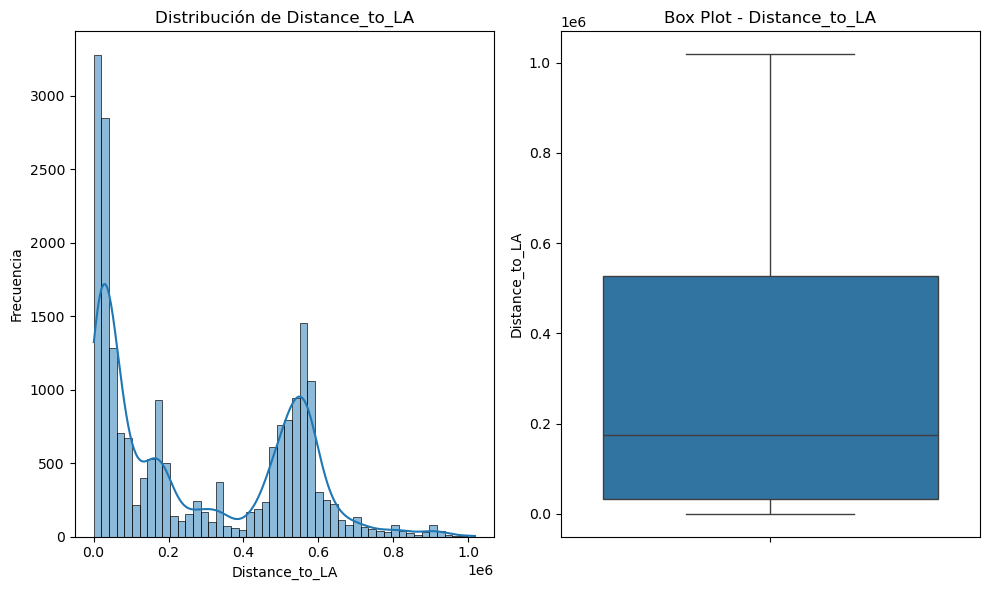


=== ESTADÍSTICAS DE Distance_to_LA ===
Media: 269421.98
Mediana: 173667.46
Desviación estándar: 247732.45
Valores únicos: 12590
Valores nulos: 0
--------------------------------------------------


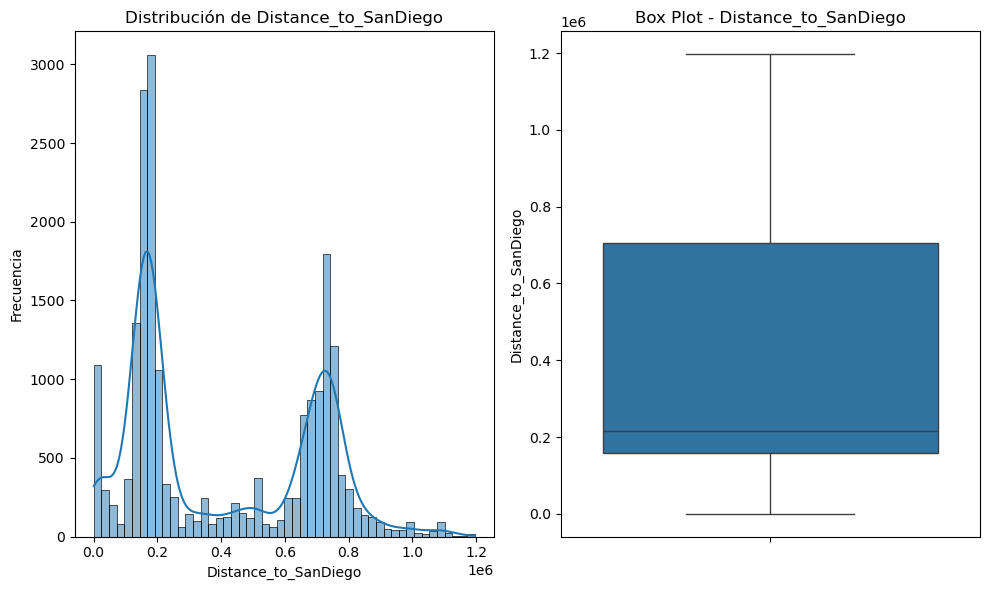


=== ESTADÍSTICAS DE Distance_to_SanDiego ===
Media: 398164.93
Mediana: 214739.83
Desviación estándar: 289400.56
Valores únicos: 12590
Valores nulos: 0
--------------------------------------------------


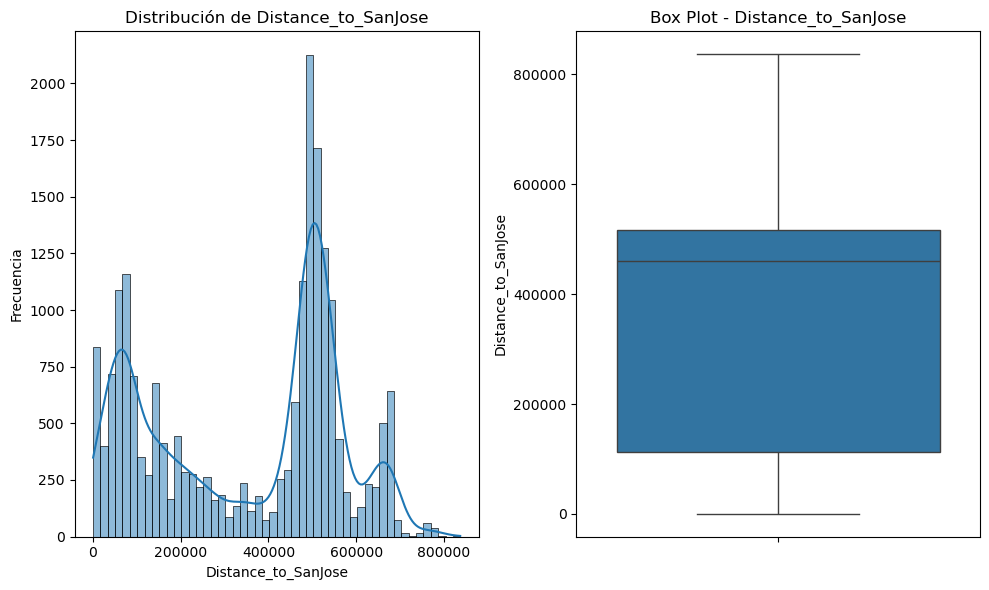


=== ESTADÍSTICAS DE Distance_to_SanJose ===
Media: 349187.55
Mediana: 459758.88
Desviación estándar: 217149.88
Valores únicos: 12590
Valores nulos: 0
--------------------------------------------------


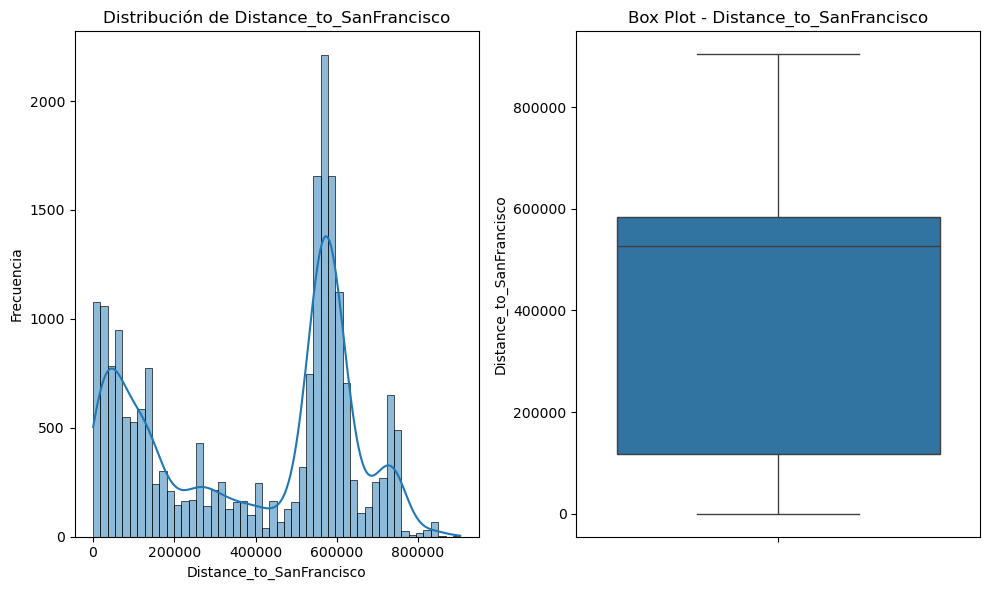


=== ESTADÍSTICAS DE Distance_to_SanFrancisco ===
Media: 386688.42
Mediana: 526546.66
Desviación estándar: 250122.19
Valores únicos: 12590
Valores nulos: 0
--------------------------------------------------


In [124]:
def clear_hist(data, x=None, columns=None):
    """
    Función para crear histograma limpio de una o múltiples variables
    
    Parámetros:
    - data: DataFrame con los datos
    - x: Variable específica (str) - para una sola variable
    - columns: Lista de columnas o 'all' para todas las numéricas
    """
    
    # Determinar qué columnas procesar
    if x is not None:
        # Modo individual: una sola variable
        cols_to_plot = [x]
    elif columns == 'all':
        # Modo todas: solo columnas numéricas
        cols_to_plot = data.select_dtypes(include=[np.number]).columns.tolist()
    elif columns is not None:
        # Modo lista: columnas específicas
        cols_to_plot = columns if isinstance(columns, list) else [columns]
    else:
        # Por defecto: solo columnas numéricas
        cols_to_plot = data.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"📊 Creando histogramas para {len(cols_to_plot)} variable(s)...")
    
    # Procesar cada columna
    for col in cols_to_plot:
        if col not in data.columns:
            print(f"⚠️  Columna '{col}' no encontrada. Saltando...")
            continue
            
        if not pd.api.types.is_numeric_dtype(data[col]):
            print(f"⚠️  Columna '{col}' no es numérica. Saltando...")
            continue
        
        # Crear figura para cada variable
        plt.figure(figsize=(10, 6))
        
        # Histograma con KDE
        plt.subplot(1, 2, 1)
        try:
            sns.histplot(data=data, x=col, kde=True, bins=50)
            plt.title(f'Distribución de {col}')
            plt.xlabel(col)
            plt.ylabel('Frecuencia')
        except Exception as e:
            print(f"Error creando histograma para {col}: {e}")
            continue
        
        # Box plot para identificar outliers
        plt.subplot(1, 2, 2)
        try:
            sns.boxplot(data=data, y=col)
            plt.title(f'Box Plot - {col}')
        except Exception as e:
            print(f"Error creando boxplot para {col}: {e}")
            continue
        
        plt.tight_layout()
        plt.show()
        
        # Estadísticas de la variable
        print(f"\n=== ESTADÍSTICAS DE {col} ===")
        try:
            print(f"Media: {data[col].mean():.2f}")
            print(f"Mediana: {data[col].median():.2f}")
            print(f"Desviación estándar: {data[col].std():.2f}")
            print(f"Valores únicos: {data[col].nunique()}")
            print(f"Valores nulos: {data[col].isnull().sum()}")
            print("-" * 50)
        except Exception as e:
            print(f"Error calculando estadísticas para {col}: {e}")
            print("-" * 50)

clear_hist(data, x=None, columns=None)

## 3.2 Truncando la variable

In [128]:
def preprocess_data_advanced(data):
    """
    Preprocesamiento avanzado basado en el análisis de distribuciones
    """
    print("=== INICIANDO PREPROCESAMIENTO AVANZADO ===")
    data_processed = data.copy()
    
    # 1. MEDIAN_HOUSE_VALUE (Variable Objetivo)
    print("\n🏠 PROCESANDO MEDIAN_HOUSE_VALUE:")
    print("- Distribución: Sesgada a la derecha con cap en 500,001")
    print("- Problema: Truncamiento artificial en valores máximos")
    print("- Solución: Mantener cap pero aplicar transformación log")
    
    # Mantener el cap original pero marcar casos extremos
    data_processed['Is_Max_Value'] = (data_processed['Median_House_Value'] >= 500000).astype(int)
    # Transformación logarítmica para reducir sesgo
    data_processed['Log_House_Value'] = np.log1p(data_processed['Median_House_Value'])
    
    # 2. MEDIAN_INCOME
    print("\n💰 PROCESANDO MEDIAN_INCOME:")
    print("- Distribución: Sesgada a la derecha con outliers extremos (>15)")
    print("- Problema: Algunos valores muy altos distorsionan el modelo")
    print("- Solución: Winsorización en percentil 95 (≈8.0)")
    
    income_95 = data_processed['Median_Income'].quantile(0.95)
    data_processed['Median_Income_Original'] = data_processed['Median_Income'].copy()
    data_processed['Median_Income'] = np.clip(data_processed['Median_Income'], 0, income_95)
    outliers_income = (data_processed['Median_Income_Original'] > income_95).sum()
    print(f"- Outliers truncados: {outliers_income} ({outliers_income/len(data)*100:.1f}%)")
    
    # 3. MEDIAN_AGE
    print("\n🏘️ PROCESANDO MEDIAN_AGE:")
    print("- Distribución: Bimodal con picos en ~25 y ~52 años")
    print("- Problema: Cap artificial en 52 años, distribución no normal")
    print("- Solución: Crear variables categóricas + mantener continua")
    
    # Crear categorías basadas en la distribución observada
    data_processed['Age_Category'] = pd.cut(data_processed['Median_Age'], 
                                          bins=[0, 15, 25, 35, 45, 52], 
                                          labels=['Very_New', 'New', 'Medium', 'Old', 'Very_Old'])
    data_processed['Is_Max_Age'] = (data_processed['Median_Age'] >= 52).astype(int)
    
    # 4. TOT_ROOMS
    print("\n🏠 PROCESANDO TOT_ROOMS:")
    print("- Distribución: Altamente sesgada con outliers extremos (>20,000)")
    print("- Problema: Mayoría de valores <5,000 pero algunos >30,000")
    print("- Solución: Winsorización en percentil 98 + transformación log")
    
    rooms_98 = data_processed['Tot_Rooms'].quantile(0.98)
    data_processed['Tot_Rooms_Original'] = data_processed['Tot_Rooms'].copy()
    data_processed['Tot_Rooms'] = np.clip(data_processed['Tot_Rooms'], 1, rooms_98)
    data_processed['Log_Tot_Rooms'] = np.log1p(data_processed['Tot_Rooms'])
    outliers_rooms = (data_processed['Tot_Rooms_Original'] > rooms_98).sum()
    print(f"- Outliers truncados: {outliers_rooms} ({outliers_rooms/len(data)*100:.1f}%)")
    
    # 5. TOT_BEDROOMS (Similar tratamiento a Tot_Rooms)
    print("\n🛏️ PROCESANDO TOT_BEDROOMS:")
    bedrooms_98 = data_processed['Tot_Bedrooms'].quantile(0.98)
    data_processed['Tot_Bedrooms'] = np.clip(data_processed['Tot_Bedrooms'], 1, bedrooms_98)
    data_processed['Log_Tot_Bedrooms'] = np.log1p(data_processed['Tot_Bedrooms'])
    
    # 6. POPULATION
    print("\n👥 PROCESANDO POPULATION:")
    print("- Distribución: Extremadamente sesgada, mayoría <5,000")
    print("- Problema: Outliers hasta 35,682 personas")
    print("- Solución: Winsorización percentil 97 + transformación log")
    
    pop_97 = data_processed['Population'].quantile(0.97)
    data_processed['Population_Original'] = data_processed['Population'].copy()
    data_processed['Population'] = np.clip(data_processed['Population'], 1, pop_97)
    data_processed['Log_Population'] = np.log1p(data_processed['Population'])
    outliers_pop = (data_processed['Population_Original'] > pop_97).sum()
    print(f"- Outliers truncados: {outliers_pop} ({outliers_pop/len(data)*100:.1f}%)")
    
    # 7. HOUSEHOLDS
    print("\n🏡 PROCESANDO HOUSEHOLDS:")
    print("- Similar a Population, winsorización percentil 97")
    households_97 = data_processed['Households'].quantile(0.97)
    data_processed['Households'] = np.clip(data_processed['Households'], 1, households_97)
    data_processed['Log_Households'] = np.log1p(data_processed['Households'])
    
    # 8. VARIABLES GEOGRÁFICAS - TRATAMIENTO ESPECÍFICO
    print("\n🌍 PROCESANDO VARIABLES GEOGRÁFICAS:")
    
    # DISTANCE_TO_COAST
    print("- Distance_to_coast: Muy sesgada, muchos cerca de costa")
    print("- Solución: Crear categorías + transformación log")
    data_processed['Log_Distance_Coast'] = np.log1p(data_processed['Distance_to_coast'])
    data_processed['Coastal_Category'] = pd.cut(data_processed['Distance_to_coast'],
                                               bins=[0, 5000, 20000, 50000, float('inf')],
                                               labels=['Coastal', 'Near_Coast', 'Inland', 'Far_Inland'])
    
    # DISTANCIAS A CIUDADES - Distribuciones bimodales
    print("- Distancias a ciudades: Distribuciones bimodales características")
    print("- Solución: Normalización robusta + categorías por proximidad")
    
    city_distances = ['Distance_to_LA', 'Distance_to_SanDiego', 'Distance_to_SanJose', 'Distance_to_SanFrancisco']
    
    for city_dist in city_distances:
        # Transformación log
        data_processed[f'Log_{city_dist}'] = np.log1p(data_processed[city_dist])
        
        # Crear categorías de proximidad (terciles)
        data_processed[f'{city_dist}_Category'] = pd.qcut(data_processed[city_dist], 
                                                         q=3, 
                                                         labels=['Close', 'Medium', 'Far'])
    
    # 9. VARIABLES DERIVADAS MEJORADAS
    print("\n🔧 CREANDO VARIABLES DERIVADAS MEJORADAS:")
    
    # Ratios robustos (evitar división por cero)
    data_processed['Avg_Rooms_per_Household'] = (data_processed['Tot_Rooms'] / 
                                                np.maximum(data_processed['Households'], 1))
    data_processed['Avg_Bedrooms_per_Household'] = (data_processed['Tot_Bedrooms'] / 
                                                   np.maximum(data_processed['Households'], 1))
    data_processed['Population_per_Household'] = (data_processed['Population'] / 
                                                 np.maximum(data_processed['Households'], 1))
    data_processed['Bedroom_Ratio'] = (data_processed['Tot_Bedrooms'] / 
                                      np.maximum(data_processed['Tot_Rooms'], 1))
    
    # Variable de densidad geográfica
    data_processed['Population_Density'] = data_processed['Population'] / (data_processed['Tot_Rooms'] / 10)
    
    # Variable de proximidad general (distancia mínima a cualquier ciudad importante)
    data_processed['Min_City_Distance'] = data_processed[city_distances].min(axis=1)
    data_processed['Log_Min_City_Distance'] = np.log1p(data_processed['Min_City_Distance'])
    
    # 10. VARIABLES GEOGRÁFICAS COMBINADAS
    print("\n📍 CREANDO VARIABLES GEOGRÁFICAS COMBINADAS:")
    
    # Crear variable de "deseabilidad geográfica"
    # (Combina proximidad a costa y ciudades)
    coast_weight = 1 / (1 + data_processed['Distance_to_coast'] / 10000)
    city_weight = 1 / (1 + data_processed['Min_City_Distance'] / 100000)
    data_processed['Geographic_Desirability'] = (coast_weight + city_weight) / 2
    
    # 11. DETECCIÓN Y MARCADO DE OUTLIERS MULTIVARIADOS
    print("\n🎯 MARCANDO OUTLIERS MULTIVARIADOS:")
    
    # Identificar casos con múltiples características extremas
    outlier_flags = []
    outlier_flags.append(data_processed['Median_Income_Original'] > data_processed['Median_Income_Original'].quantile(0.99))
    outlier_flags.append(data_processed['Tot_Rooms_Original'] > data_processed['Tot_Rooms_Original'].quantile(0.99))
    outlier_flags.append(data_processed['Population_Original'] > data_processed['Population_Original'].quantile(0.99))
    
    data_processed['Multiple_Outlier_Flag'] = sum(outlier_flags).astype(int)
    
    print(f"\n📊 RESUMEN DEL PREPROCESAMIENTO:")
    print(f"- Variables originales: {len([c for c in data.columns])}")
    print(f"- Variables después del procesamiento: {len([c for c in data_processed.columns])}")
    print(f"- Variables log creadas: {len([c for c in data_processed.columns if 'Log_' in c])}")
    print(f"- Variables categóricas creadas: {len([c for c in data_processed.columns if 'Category' in c])}")
    print(f"- Casos con outliers múltiples: {data_processed['Multiple_Outlier_Flag'].sum()}")

    return data_processed
    
data_processed = preprocess_data_advanced(data)

=== INICIANDO PREPROCESAMIENTO AVANZADO ===

🏠 PROCESANDO MEDIAN_HOUSE_VALUE:
- Distribución: Sesgada a la derecha con cap en 500,001
- Problema: Truncamiento artificial en valores máximos
- Solución: Mantener cap pero aplicar transformación log

💰 PROCESANDO MEDIAN_INCOME:
- Distribución: Sesgada a la derecha con outliers extremos (>15)
- Problema: Algunos valores muy altos distorsionan el modelo
- Solución: Winsorización en percentil 95 (≈8.0)
- Outliers truncados: 1032 (5.0%)

🏘️ PROCESANDO MEDIAN_AGE:
- Distribución: Bimodal con picos en ~25 y ~52 años
- Problema: Cap artificial en 52 años, distribución no normal
- Solución: Crear variables categóricas + mantener continua

🏠 PROCESANDO TOT_ROOMS:
- Distribución: Altamente sesgada con outliers extremos (>20,000)
- Problema: Mayoría de valores <5,000 pero algunos >30,000
- Solución: Winsorización en percentil 98 + transformación log
- Outliers truncados: 413 (2.0%)

🛏️ PROCESANDO TOT_BEDROOMS:

👥 PROCESANDO POPULATION:
- Distribución

In [129]:
data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Median_House_Value                 20640 non-null  float64 
 1   Median_Income                      20640 non-null  float64 
 2   Median_Age                         20640 non-null  int64   
 3   Tot_Rooms                          20640 non-null  float64 
 4   Tot_Bedrooms                       20640 non-null  float64 
 5   Population                         20640 non-null  float64 
 6   Households                         20640 non-null  int64   
 7   Latitude                           20640 non-null  float64 
 8   Longitude                          20640 non-null  float64 
 9   Distance_to_coast                  20640 non-null  float64 
 10  Distance_to_LA                     20640 non-null  float64 
 11  Distance_to_SanDiego               20640 

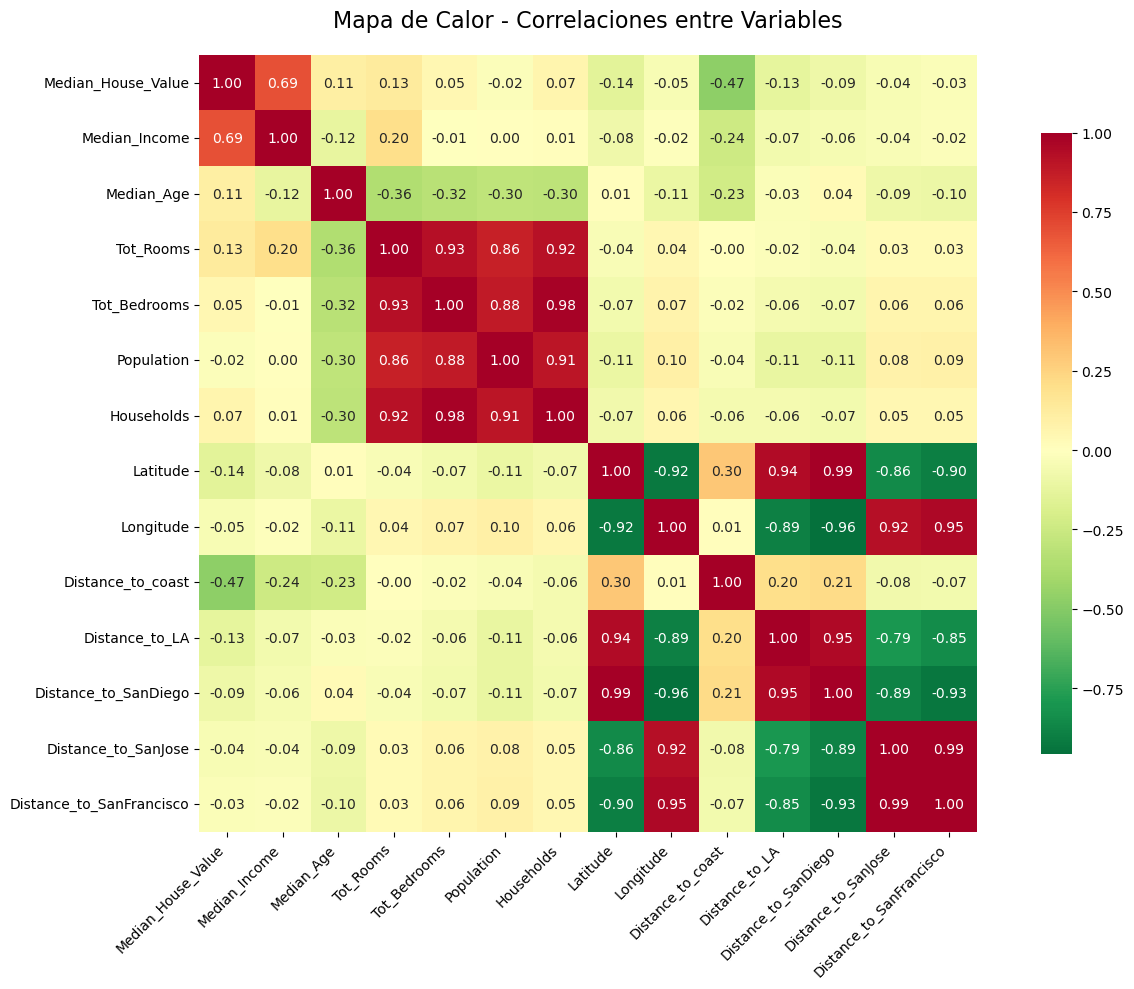

=== CORRELACIONES CON EL PRECIO DE VIVIENDA ===
Median_Income                 :  0.688
Tot_Rooms                     :  0.134
Median_Age                    :  0.106
Households                    :  0.066
Tot_Bedrooms                  :  0.051
Population                    : -0.025
Distance_to_SanFrancisco      : -0.031
Distance_to_SanJose           : -0.042
Longitude                     : -0.046
Distance_to_SanDiego          : -0.093
Distance_to_LA                : -0.131
Latitude                      : -0.144
Distance_to_coast             : -0.469


In [130]:
def visualize_correlations(data_processed):
    """
    Crear mapa de calor de correlaciones
    """
    plt.figure(figsize=(14, 10))
    corr_matrix = data.corr()
    
    # Crear el mapa de calor con la paleta invertida
    palette = sns.color_palette("RdYlGn_r", as_cmap=True)
    
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap=palette, 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    
    plt.title('Mapa de Calor - Correlaciones entre Variables', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Mostrar correlaciones más fuertes con el precio
    target_corr = corr_matrix['Median_House_Value'].sort_values(ascending=False)
    print("=== CORRELACIONES CON EL PRECIO DE VIVIENDA ===")
    for var, corr in target_corr.items():
        if var != 'Median_House_Value':
            print(f"{var:30s}: {corr:6.3f}")

#Llamar función
visualize_correlations(data_processed)

In [134]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

def advanced_feature_engineering(data_processed, target_col='Median_House_Value', test_size=0.2, random_state=42):
    """
    Feature Engineering avanzado ANTES de la selección de variables
    """
    print("=== FEATURE ENGINEERING AVANZADO ===\n")
    
    # PASO 0: USAR TU FUNCIÓN DE SELECCIÓN EXISTENTE
    print("🔍 PASO 0: Aplicando selección de variables existente...")
    
    # Importar tu función (asumiendo que está disponible)
    try:
        X_selected, y, variables_finales, selection_results = advanced_feature_selection(data_processed, target_col)
        print(f"  ✓ Variables seleccionadas: {len(variables_finales)}")
    except NameError:
        print("  ⚠️ Función de selección no encontrada, usando datos originales")
        X_selected = data_processed.drop([target_col], axis=1)
        y = data_processed[target_col]
    
    # Crear copia para trabajar
    X_enhanced = X_selected.copy()
    
    # 1. CREAR VARIABLES DE INTERACCIÓN
    print("🔗 PASO 1: Creando variables de interacción...")
    
    # Verificar qué variables están disponibles después de la selección
    available_vars = X_enhanced.columns.tolist()
    
    # Interacciones clave basadas en variables disponibles
    potential_interactions = [
        ('Median_Income', 'Geographic_Desirability'),
        ('Median_Income', 'Log_Distance_Coast'),
        ('Median_Income', 'Distance_to_coast'),
        ('Geographic_Desirability', 'Log_Distance_Coast'),
        ('Median_Age', 'Is_Max_Value'),
        ('Bedroom_Ratio', 'Log_Tot_Rooms'),
        ('Population_Density', 'Median_Age'),
        ('Min_City_Distance', 'Distance_to_coast'),
        ('Log_Min_City_Distance', 'Log_Distance_Coast'),
        ('Is_Max_Value', 'Geographic_Desirability')
    ]
    
    interactions_created = 0
    for var1, var2 in potential_interactions:
        if var1 in available_vars and var2 in available_vars:
            interaction_name = f"{var1}_x_{var2}"
            X_enhanced[interaction_name] = X_enhanced[var1] * X_enhanced[var2]
            interactions_created += 1
            print(f"  ✓ {interaction_name}")
    
    print(f"  Total interacciones creadas: {interactions_created}")
    
    # 2. CREAR RATIOS Y PROPORCIONES ADICIONALES
    print(f"\n📊 PASO 2: Creando ratios y proporciones...")
    
    ratios_created = 0
    
    # Ratios geográficos (si las variables están disponibles)
    if 'Distance_to_coast' in available_vars and 'Min_City_Distance' in available_vars:
        X_enhanced['Coast_to_City_Ratio'] = (
            X_enhanced['Distance_to_coast'] / 
            (X_enhanced['Min_City_Distance'] + 1)
        )
        ratios_created += 1
        print("  ✓ Coast_to_City_Ratio")
    
    # Ratio de deseabilidad por ingreso
    if 'Geographic_Desirability' in available_vars and 'Median_Income' in available_vars:
        X_enhanced['Desirability_per_Income'] = (
            X_enhanced['Geographic_Desirability'] / 
            (X_enhanced['Median_Income'] + 0.1)
        )
        ratios_created += 1
        print("  ✓ Desirability_per_Income")
    
    # Ratios adicionales basados en variables disponibles
    if 'Log_Tot_Rooms' in available_vars and 'Median_Age' in available_vars:
        X_enhanced['Rooms_per_Age'] = X_enhanced['Log_Tot_Rooms'] / (X_enhanced['Median_Age'] + 1)
        ratios_created += 1
        print("  ✓ Rooms_per_Age")
    
    if 'Bedroom_Ratio' in available_vars and 'Median_Income' in available_vars:
        X_enhanced['Bedroom_Income_Ratio'] = X_enhanced['Bedroom_Ratio'] * X_enhanced['Median_Income']
        ratios_created += 1
        print("  ✓ Bedroom_Income_Ratio")
    
    print(f"  Total ratios creados: {ratios_created}")
    
    # 3. VARIABLES POLINÓMICAS PARA VARIABLES CLAVE
    print(f"\n🔢 PASO 3: Creando características polinómicas...")
    
    # Variables clave para transformación polinómica (verificar disponibilidad)
    potential_poly_vars = ['Median_Income', 'Geographic_Desirability', 'Log_Distance_Coast', 'Log_Tot_Rooms']
    poly_vars = [var for var in potential_poly_vars if var in available_vars]
    
    polynomials_created = 0
    for var in poly_vars:
        # Cuadrado
        X_enhanced[f"{var}_squared"] = X_enhanced[var] ** 2
        polynomials_created += 1
        
        # Cubo (solo para las más importantes)
        if var in ['Median_Income', 'Geographic_Desirability']:
            X_enhanced[f"{var}_cubed"] = X_enhanced[var] ** 3
            polynomials_created += 1
        
        print(f"  ✓ {var} → transformaciones polinómicas")
    
    print(f"  Total transformaciones polinómicas: {polynomials_created}")
    
    # 4. BINNING DE VARIABLES CONTINUAS
    print(f"\n📦 PASO 4: Creando variables categóricas por binning...")
    
    # Binning inteligente basado en cuantiles (solo si las variables están disponibles)
    potential_binning_vars = {
        'Median_Income': ['Low_Income', 'Mid_Income', 'High_Income', 'Very_High_Income'],
        'Median_Age': ['New_Houses', 'Medium_Age', 'Old_Houses'],
        'Log_Tot_Rooms': ['Small_Homes', 'Medium_Homes', 'Large_Homes']
    }
    
    binning_created = 0
    for var, labels in potential_binning_vars.items():
        if var in available_vars:
            try:
                X_enhanced[f"{var}_Binned"] = pd.qcut(
                    X_enhanced[var], 
                    q=len(labels), 
                    labels=labels, 
                    duplicates='drop'
                )
                binning_created += 1
                print(f"  ✓ {var} → {len(labels)} bins")
            except Exception as e:
                print(f"  ⚠️ No se pudo crear binning para {var}: {str(e)}")
    
    print(f"  Total variables de binning: {binning_created}")
    
    # 5. VARIABLES DE OUTLIERS Y EXTREMOS
    print(f"\n🎯 PASO 5: Identificando patrones extremos...")
    
    # Marcar valores extremos en variables clave (solo si están disponibles)
    potential_extreme_vars = ['Median_Income', 'Log_Tot_Rooms', 'Median_Age']
    extreme_vars = [var for var in potential_extreme_vars if var in available_vars]
    
    extremes_created = 0
    for var in extreme_vars:
        try:
            q99 = X_enhanced[var].quantile(0.99)
            q01 = X_enhanced[var].quantile(0.01)
            
            X_enhanced[f"{var}_IsExtreme"] = (
                (X_enhanced[var] >= q99) | (X_enhanced[var] <= q01)
            ).astype(int)
            extremes_created += 1
            print(f"  ✓ {var}_IsExtreme")
        except Exception as e:
            print(f"  ⚠️ No se pudo crear variable extrema para {var}: {str(e)}")
    
    # Variable de "lujo" combinada (solo si las variables necesarias están disponibles)
    luxury_vars_needed = ['Median_Income', 'Geographic_Desirability']
    if all(var in available_vars for var in luxury_vars_needed):
        try:
            luxury_score = (
                (X_enhanced['Median_Income'] > X_enhanced['Median_Income'].quantile(0.8)) &
                (X_enhanced['Geographic_Desirability'] > X_enhanced['Geographic_Desirability'].quantile(0.8))
            ).astype(int)
            
            X_enhanced['Luxury_Area_Flag'] = luxury_score
            extremes_created += 1
            print(f"  ✓ Luxury_Area_Flag")
        except Exception as e:
            print(f"  ⚠️ No se pudo crear Luxury_Area_Flag: {str(e)}")
    
    print(f"  Total variables de extremos: {extremes_created}")
    
    # 6. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
    print(f"\n🔄 PASO 6: Codificando variables categóricas...")
    
    label_encoders = {}
    categorical_cols = X_enhanced.select_dtypes(include=['category', 'object']).columns
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_enhanced[col] = le.fit_transform(X_enhanced[col].astype(str))
        label_encoders[col] = le
        print(f"  ✓ {col}: {len(le.classes_)} categorías")
    
    # 7. SELECCIÓN DE CARACTERÍSTICAS FINAL
    print(f"\n⚡ PASO 7: Selección final de características...")
    
    # Dividir datos antes de la selección
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X_enhanced, y, test_size=test_size, random_state=random_state
    )
    
    # Selección por correlación (eliminar muy poco correlacionadas)
    numeric_cols = X_train_temp.select_dtypes(include=[np.number]).columns
    correlations = {}
    
    for col in numeric_cols:
        if col != 'Median_House_Value':  # Evitar target
            corr = abs(np.corrcoef(X_train_temp[col], y_train_temp)[0, 1])
            if not np.isnan(corr):
                correlations[col] = corr
    
    # Mantener variables con correlación > 0.01
    min_correlation = 0.01
    relevant_vars = [var for var, corr in correlations.items() if corr > min_correlation]
    
    # Añadir variables categóricas
    categorical_vars = [col for col in X_enhanced.columns if col not in numeric_cols]
    final_vars = relevant_vars + categorical_vars
    
    X_final_enhanced = X_enhanced[final_vars].copy()
    
    print(f"  ✓ Variables con correlación > {min_correlation}: {len(relevant_vars)}")
    print(f"  ✓ Variables categóricas mantenidas: {len(categorical_vars)}")
    print(f"  ✓ Total variables finales: {len(final_vars)}")
    
    # 8. DIVISIÓN Y ESCALADO FINAL
    print(f"\n📊 PASO 8: División y escalado final...")
    
    # División final
    X_train, X_test, y_train, y_test = train_test_split(
        X_final_enhanced, y, test_size=test_size, random_state=random_state
    )
    
    # Escalado solo de variables numéricas
    numeric_cols_final = X_train.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numeric_cols_final] = scaler.fit_transform(X_train[numeric_cols_final])
    X_test_scaled[numeric_cols_final] = scaler.transform(X_test[numeric_cols_final])
    
    print(f"  ✓ Train set: {X_train.shape}")
    print(f"  ✓ Test set: {X_test.shape}")
    print(f"  ✓ Variables numéricas escaladas: {len(numeric_cols_final)}")
    
    # 9. RESUMEN FINAL
    print(f"\n📋 RESUMEN DEL FEATURE ENGINEERING:")
    print(f"  Variables después de selección: {X_selected.shape[1]}")
    print(f"  Variables después del engineering: {X_final_enhanced.shape[1]}")
    print(f"  Incremento: +{X_final_enhanced.shape[1] - X_selected.shape[1]} variables")
    print(f"  Variables de interacción: {interactions_created}")
    print(f"  Variables polinómicas: {polynomials_created}")
    print(f"  Variables ratios: {ratios_created}")
    print(f"  Variables de binning: {binning_created}")
    print(f"  Variables de extremos: {extremes_created}")
    
    # Estadísticas del target
    print(f"\n🎯 ESTADÍSTICAS DEL TARGET:")
    print(f"  Media: ${y_train.mean():,.0f}")
    print(f"  Mediana: ${y_train.median():,.0f}")
    print(f"  Desviación: ${y_train.std():,.0f}")
    print(f"  Rango: ${y_train.min():,.0f} - ${y_train.max():,.0f}")
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'feature_names': list(X_final_enhanced.columns),
        'numeric_features': list(numeric_cols_final),
        'categorical_features': categorical_vars,
        'correlations': correlations
    }

def analyze_feature_engineering_impact(data_dict):
    """
    Analizar el impacto del feature engineering
    """
    print("\n=== ANÁLISIS DEL IMPACTO DEL FEATURE ENGINEERING ===\n")
    
    # Top correlaciones con el target
    print("🔝 TOP 15 CORRELACIONES CON EL TARGET:")
    sorted_corr = sorted(data_dict['correlations'].items(), key=lambda x: x[1], reverse=True)
    
    for i, (var, corr) in enumerate(sorted_corr[:15], 1):
        # Identificar tipo de variable
        if 'squared' in var or 'cubed' in var:
            tipo = "🔢 Polinómica"
        elif '_x_' in var:
            tipo = "🔗 Interacción"
        elif 'IsExtreme' in var or 'Flag' in var:
            tipo = "🎯 Extremo"
        elif 'Ratio' in var:
            tipo = "📊 Ratio"
        elif 'Binned' in var:
            tipo = "📦 Binning"
        else:
            tipo = "📈 Original/Derivada"
        
        print(f"{i:2d}. {var:<40s}: {corr:.4f} {tipo}")
    
    # Detectar posibles redundancias restantes
    print(f"\n🔍 ANÁLISIS DE REDUNDANCIAS RESTANTES:")
    
    feature_names = data_dict['feature_names']
    
    # Agrupar variables similares
    income_vars = [f for f in feature_names if 'Median_Income' in f]
    geo_vars = [f for f in feature_names if 'Geographic_Desirability' in f]
    distance_vars = [f for f in feature_names if 'Distance' in f and 'Log' in f]
    
    print(f"  Variables de Median_Income: {len(income_vars)}")
    for var in income_vars:
        corr = data_dict['correlations'].get(var, 0)
        print(f"    • {var}: {corr:.4f}")
    
    print(f"  Variables de Geographic_Desirability: {len(geo_vars)}")
    for var in geo_vars:
        corr = data_dict['correlations'].get(var, 0)
        print(f"    • {var}: {corr:.4f}")
    
    # Contar tipos de variables
    counts = {
        'Originales': len([f for f in feature_names if not any(x in f for x in ['squared', 'cubed', '_x_', 'IsExtreme', 'Flag', 'Binned', 'Ratio'])]),
        'Interacciones': len([f for f in feature_names if '_x_' in f]),
        'Polinómicas': len([f for f in feature_names if 'squared' in f or 'cubed' in f]),
        'Binning': len([f for f in feature_names if 'Binned' in f]),
        'Extremos/Flags': len([f for f in feature_names if 'IsExtreme' in f or 'Flag' in f]),
        'Ratios': len([f for f in feature_names if 'Ratio' in f])
    }
    
    print(f"\n📊 DISTRIBUCIÓN DE TIPOS DE VARIABLES:")
    for tipo, count in counts.items():
        print(f"  {tipo}: {count}")
    
    # Calcular mejora vs variables originales
    original_vars = [f for f in feature_names if not any(x in f for x in ['squared', 'cubed', '_x_', 'IsExtreme', 'Flag', 'Binned', 'Ratio'])]
    created_vars = [f for f in feature_names if f not in original_vars]
    
    if len(created_vars) > 0:
        original_corrs = [data_dict['correlations'].get(var, 0) for var in original_vars if var in data_dict['correlations']]
        created_corrs = [data_dict['correlations'].get(var, 0) for var in created_vars if var in data_dict['correlations']]
        
        if original_corrs and created_corrs:
            print(f"\n📈 MEJORA POR FEATURE ENGINEERING:")
            print(f"  Mejor correlación original: {max(original_corrs):.4f}")
            print(f"  Mejor correlación creada: {max(created_corrs):.4f}")
            print(f"  Mejora: +{max(created_corrs) - max(original_corrs):.4f}")
    
    print(f"\n✅ Dataset optimizado con {len(feature_names)} características (redundancias eliminadas)!")
    
    return counts

# Función para usar el feature engineering integrado
def prepare_data_for_modeling(data_processed, target_col='Median_House_Value'):
    """
    Función principal que combina tu selección existente + feature engineering
    """
    print("🚀 INICIANDO PREPARACIÓN COMPLETA DE DATOS...\n")
    
    # Aplicar feature engineering (que incluye tu selección)
    data_dict = advanced_feature_engineering(data_processed, target_col)
    
    # Analizar impacto
    feature_counts = analyze_feature_engineering_impact(data_dict)
    
    return data_dict

# Ejemplo de uso CON TU FUNCIÓN EXISTENTE:
data_dict = prepare_data_for_modeling(data_processed)

🚀 INICIANDO PREPARACIÓN COMPLETA DE DATOS...

=== FEATURE ENGINEERING AVANZADO ===

🔍 PASO 0: Aplicando selección de variables existente...
=== SELECCIÓN AVANZADA DE VARIABLES ===

🚫 PASO 1: Eliminando variables redundantes obvias...
Variables eliminadas: 18
Variables restantes: 25

📊 PASO 2: Análisis de correlación con Median_House_Value...

Top 10 correlaciones con el target:
Median_Income                      : 0.680
Is_Max_Value                       : 0.571
Geographic_Desirability            : 0.518
Log_Distance_Coast                 : 0.498
Distance_to_coast                  : 0.469
Min_City_Distance                  : 0.435
Log_Min_City_Distance              : 0.390
Bedroom_Ratio                      : 0.255
Log_Distance_to_SanFrancisco       : 0.163
Log_Tot_Rooms                      : 0.160

🌲 PASO 3: Importancia por Random Forest...

Top 10 variables por importancia Random Forest:
Is_Max_Value                       : 0.3195
Median_Income                      : 0.2472
Geograph

# **4. Construcción de Modelos**


---

## 4.1 xgboost

✅ XGBoost disponible
🚀 INICIANDO ANÁLISIS COMPLETO XGBOOST...

=== ENTRENAMIENTO MODELO XGBOOST ===

📊 Datos de entrenamiento: (16512, 41)
📊 Datos de prueba: (4128, 41)

🔧 PASO 1: Entrenando modelo base...
  ✓ R² Test (base): 0.8630
  ✓ RMSE Test (base): $42,365
  ✓ MAE Test (base): $28,446

🎯 PASO 2: Optimizando hiperparámetros...
  🔍 Ejecutando búsqueda aleatoria...
  ✓ Mejor CV Score: 0.8633
  ✓ Mejores parámetros encontrados:
    subsample: 0.9
    reg_lambda: 1.5
    reg_alpha: 0.5
    n_estimators: 300
    max_depth: 6
    learning_rate: 0.15
    colsample_bytree: 1.0

📈 MEJORA DESPUÉS DE OPTIMIZACIÓN:
  R² Test: 0.8630 → 0.8686 (+0.0055)
  RMSE Test: $42,365 → $41,503 (-862)

🔄 PASO 3: Validación cruzada...
  ✓ CV R² Mean: 0.8674 ± 0.0054
  ✓ CV R² Range: [0.8608, 0.8737]

🎯 PASO 4: Análisis de importancia de variables...
  ✓ Top 10 variables más importantes:
     1. Is_Max_Value                       : 0.3879
     2. Median_Income_x_Geographic_Desirability: 0.3553
     3. Dista

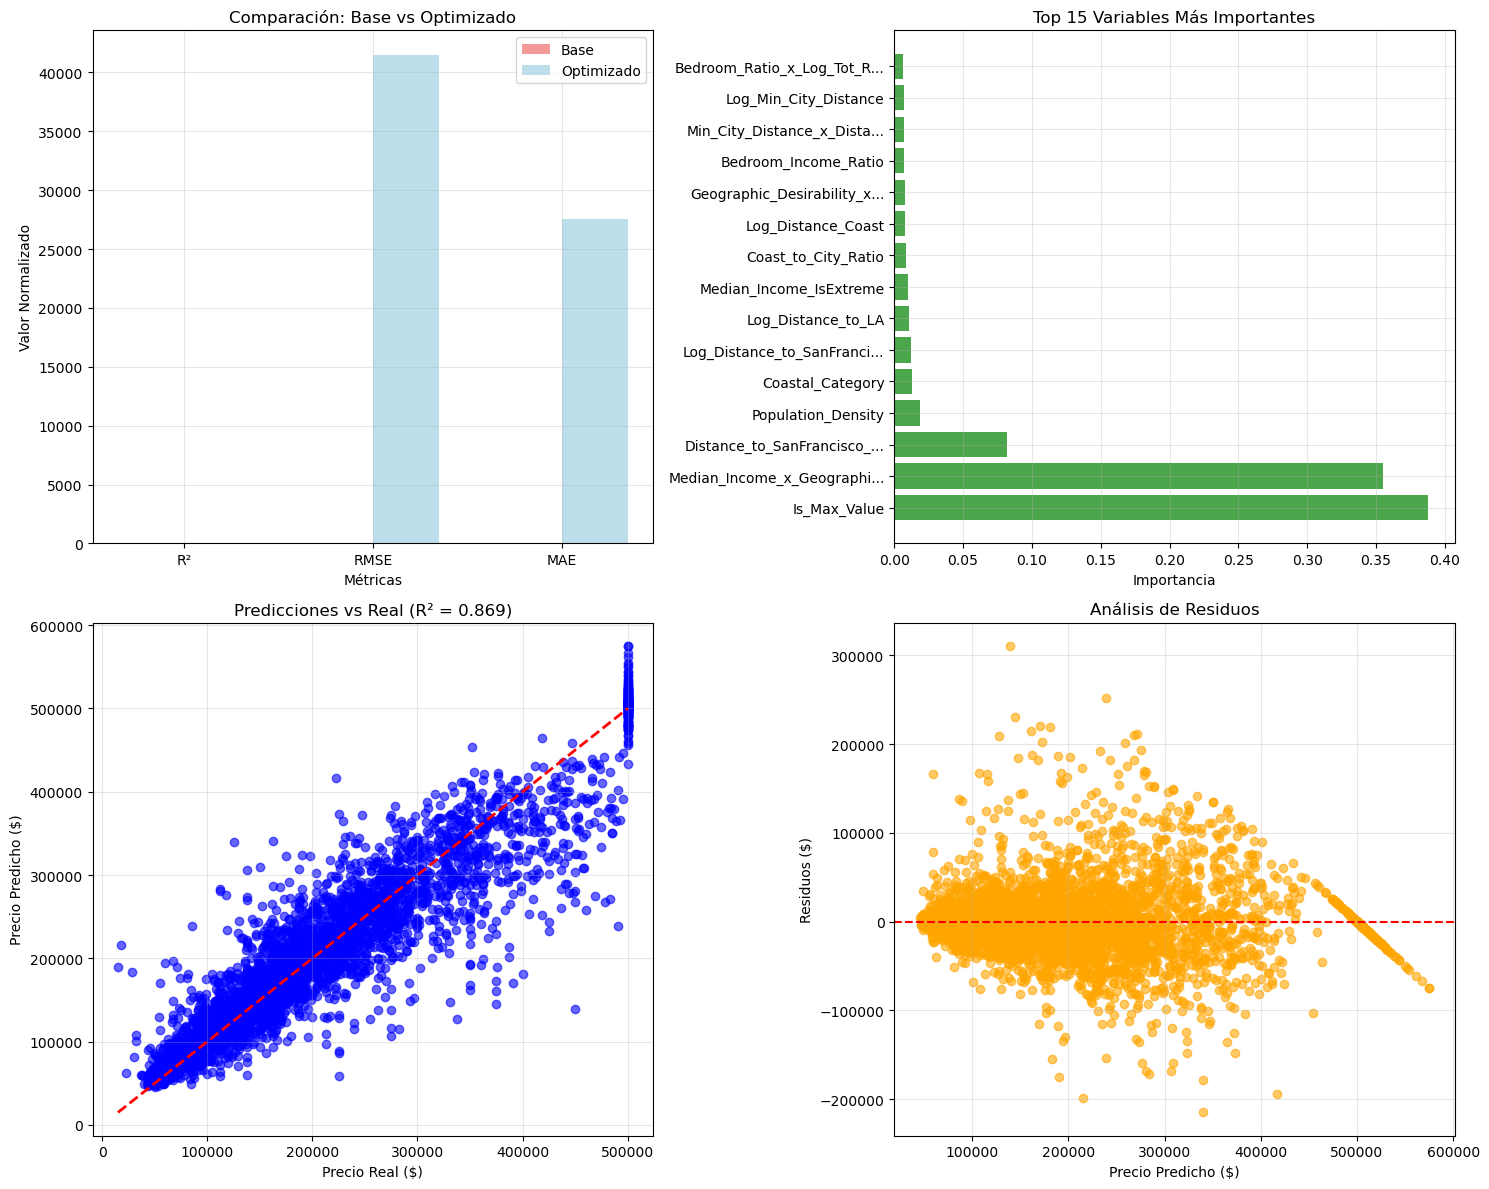

📈 ANÁLISIS DE RESIDUOS:
  Media: $295
  Std: $41,507
  MAE: $27,538
  % dentro de ±$50k: 85.1%
  % dentro de ±$100k: 96.1%

=== ANÁLISIS DETALLADO PREDICCIONES XGBOOST ===

💰 ANÁLISIS POR RANGOS DE PRECIO:
  Bajo (<$200k):
    Casos: 2414 (58.5%)
    R²: 0.505
    MAE: $20,448
  Medio ($200k-$350k):
    Casos: 1196 (29.0%)
    R²: -0.103
    MAE: $31,816
  Alto ($350k-$500k):
    Casos: 334 (8.1%)
    R²: -3.788
    MAE: $70,408
  Premium (>$500k):
    Casos: 184 (4.5%)
    R²: -16386126326.334
    MAE: $14,932

🎯 CASOS MEJOR Y PEOR PREDICHOS:
  ✅ 5 MEJORES PREDICCIONES:
    1. Real: $145,600, Pred: $145,643, Error: $43
    2. Real: $52,400, Pred: $52,444, Error: $44
    3. Real: $81,900, Pred: $81,950, Error: $50
    4. Real: $229,200, Pred: $229,142, Error: $58
    5. Real: $113,500, Pred: $113,442, Error: $58
  ❌ 5 PEORES PREDICCIONES:
    1. Real: $450,000, Pred: $139,315, Error: $310,685
    2. Real: $491,200, Pred: $238,904, Error: $252,296
    3. Real: $375,000, Pred: $144,669, 

In [136]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Importar XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost disponible")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("❌ XGBoost no instalado. Ejecutar: pip install xgboost")

def train_xgboost_model(data_dict, optimize_hyperparams=True, use_gpu=False):
    """
    Entrenar modelo XGBoost con optimización de hiperparámetros
    """
    if not XGBOOST_AVAILABLE:
        print("❌ XGBoost no está disponible. Instalar con: pip install xgboost")
        return None
    
    print("=== ENTRENAMIENTO MODELO XGBOOST ===\n")
    
    # Extraer datos
    X_train = data_dict['X_train']
    X_test = data_dict['X_test'] 
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']
    
    print(f"📊 Datos de entrenamiento: {X_train.shape}")
    print(f"📊 Datos de prueba: {X_test.shape}")
    
    # 1. MODELO BASE
    print(f"\n🔧 PASO 1: Entrenando modelo base...")
    
    # Configuración base
    base_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    # Añadir GPU si está disponible
    if use_gpu:
        try:
            base_params['tree_method'] = 'gpu_hist'
            base_params['gpu_id'] = 0
            print("🚀 Usando GPU para entrenamiento")
        except:
            print("⚠️ GPU no disponible, usando CPU")
    
    # Modelo base
    xgb_base = xgb.XGBRegressor(**base_params)
    xgb_base.fit(X_train, y_train)
    
    # Predicciones base
    y_pred_train_base = xgb_base.predict(X_train)
    y_pred_test_base = xgb_base.predict(X_test)
    
    # Métricas base
    base_metrics = {
        'train_r2': r2_score(y_train, y_pred_train_base),
        'test_r2': r2_score(y_test, y_pred_test_base),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train_base)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_base)),
        'train_mae': mean_absolute_error(y_train, y_pred_train_base),
        'test_mae': mean_absolute_error(y_test, y_pred_test_base)
    }
    
    print(f"  ✓ R² Test (base): {base_metrics['test_r2']:.4f}")
    print(f"  ✓ RMSE Test (base): ${base_metrics['test_rmse']:,.0f}")
    print(f"  ✓ MAE Test (base): ${base_metrics['test_mae']:,.0f}")
    
    # 2. OPTIMIZACIÓN DE HIPERPARÁMETROS
    best_model = xgb_base
    optimized_metrics = base_metrics
    best_params = base_params.copy()
    
    if optimize_hyperparams:
        print(f"\n🎯 PASO 2: Optimizando hiperparámetros...")
        
        # Espacio de búsqueda
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5, 6],
            'learning_rate': [0.05, 0.1, 0.15],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 0.5],
            'reg_lambda': [1, 1.5, 2]
        }
        
        # Búsqueda aleatoria (más eficiente que grid search)
        print("  🔍 Ejecutando búsqueda aleatoria...")
        
        xgb_search = xgb.XGBRegressor(**base_params)
        
        random_search = RandomizedSearchCV(
            xgb_search,
            param_distributions=param_grid,
            n_iter=50,  # 50 combinaciones aleatorias
            cv=3,       # 3-fold cross validation
            scoring='r2',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        random_search.fit(X_train, y_train)
        
        # Mejor modelo
        best_model = random_search.best_estimator_
        best_params.update(random_search.best_params_)
        
        print(f"  ✓ Mejor CV Score: {random_search.best_score_:.4f}")
        print(f"  ✓ Mejores parámetros encontrados:")
        for param, value in random_search.best_params_.items():
            print(f"    {param}: {value}")
        
        # Predicciones del modelo optimizado
        y_pred_train_opt = best_model.predict(X_train)
        y_pred_test_opt = best_model.predict(X_test)
        
        # Métricas optimizadas
        optimized_metrics = {
            'train_r2': r2_score(y_train, y_pred_train_opt),
            'test_r2': r2_score(y_test, y_pred_test_opt),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train_opt)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_opt)),
            'train_mae': mean_absolute_error(y_train, y_pred_train_opt),
            'test_mae': mean_absolute_error(y_test, y_pred_test_opt)
        }
        
        print(f"\n📈 MEJORA DESPUÉS DE OPTIMIZACIÓN:")
        print(f"  R² Test: {base_metrics['test_r2']:.4f} → {optimized_metrics['test_r2']:.4f} (+{optimized_metrics['test_r2']-base_metrics['test_r2']:.4f})")
        print(f"  RMSE Test: ${base_metrics['test_rmse']:,.0f} → ${optimized_metrics['test_rmse']:,.0f} ({optimized_metrics['test_rmse']-base_metrics['test_rmse']:+,.0f})")
    
    # 3. VALIDACIÓN CRUZADA
    print(f"\n🔄 PASO 3: Validación cruzada...")
    
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
    
    print(f"  ✓ CV R² Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  ✓ CV R² Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")
    
    # 4. ANÁLISIS DE IMPORTANCIA DE VARIABLES
    print(f"\n🎯 PASO 4: Análisis de importancia de variables...")
    
    feature_importance = pd.DataFrame({
        'Feature': data_dict['feature_names'],
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"  ✓ Top 10 variables más importantes:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"    {i:2d}. {row['Feature']:<35s}: {row['Importance']:.4f}")
    
    # 5. RESULTADOS FINALES
    print(f"\n📊 RESULTADOS FINALES XGBOOST:")
    print(f"  🎯 R² Test: {optimized_metrics['test_r2']:.4f}")
    print(f"  📏 RMSE Test: ${optimized_metrics['test_rmse']:,.0f}")
    print(f"  📐 MAE Test: ${optimized_metrics['test_mae']:,.0f}")
    print(f"  🔧 Parámetros: {len(best_params)} configurados")
    print(f"  📈 Variables: {len(data_dict['feature_names'])}")
    
    # Retornar resultados completos
    return {
        'model': best_model,
        'base_model': xgb_base,
        'metrics': optimized_metrics,
        'base_metrics': base_metrics,
        'best_params': best_params,
        'feature_importance': feature_importance,
        'cv_scores': cv_scores,
        'predictions': {
            'y_train': y_train,
            'y_test': y_test,
            'y_pred_train': best_model.predict(X_train),
            'y_pred_test': best_model.predict(X_test)
        }
    }

def visualize_xgboost_results(xgb_results):
    """
    Visualizar resultados del modelo XGBoost
    """
    print("\n=== VISUALIZACIÓN RESULTADOS XGBOOST ===\n")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Comparación métricas base vs optimizado
    if 'base_metrics' in xgb_results:
        metrics_comparison = pd.DataFrame({
            'Base': [xgb_results['base_metrics']['test_r2'], 
                    xgb_results['base_metrics']['test_rmse'],
                    xgb_results['base_metrics']['test_mae']],
            'Optimizado': [xgb_results['metrics']['test_r2'],
                          xgb_results['metrics']['test_rmse'], 
                          xgb_results['metrics']['test_mae']],
            'Métrica': ['R²', 'RMSE', 'MAE']
        })
        
        x_pos = np.arange(len(metrics_comparison))
        width = 0.35
        
        # Normalizar RMSE y MAE para visualización
        norm_base = metrics_comparison['Base'].copy()
        norm_opt = metrics_comparison['Optimizado'].copy()
        
        # Para RMSE y MAE, usar escala relativa
        norm_base[1:] = norm_base[1:] / norm_base[1:].max()
        norm_opt[1:] = norm_opt[1:] / norm_base[1:].max()
        
        axes[0,0].bar(x_pos - width/2, norm_base, width, label='Base', alpha=0.8, color='lightcoral')
        axes[0,0].bar(x_pos + width/2, norm_opt, width, label='Optimizado', alpha=0.8, color='lightblue')
        axes[0,0].set_xlabel('Métricas')
        axes[0,0].set_ylabel('Valor Normalizado')
        axes[0,0].set_title('Comparación: Base vs Optimizado')
        axes[0,0].set_xticks(x_pos)
        axes[0,0].set_xticklabels(metrics_comparison['Métrica'])
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
    
    # 2. Importancia de variables
    top_features = xgb_results['feature_importance'].head(15)
    
    axes[0,1].barh(range(len(top_features)), top_features['Importance'], color='green', alpha=0.7)
    axes[0,1].set_yticks(range(len(top_features)))
    axes[0,1].set_yticklabels([f[:25] + '...' if len(f) > 25 else f for f in top_features['Feature']])
    axes[0,1].set_xlabel('Importancia')
    axes[0,1].set_title('Top 15 Variables Más Importantes')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Predicciones vs Real
    predictions = xgb_results['predictions']
    
    axes[1,0].scatter(predictions['y_test'], predictions['y_pred_test'], alpha=0.6, color='blue')
    axes[1,0].plot([predictions['y_test'].min(), predictions['y_test'].max()], 
                   [predictions['y_test'].min(), predictions['y_test'].max()], 'r--', lw=2)
    axes[1,0].set_xlabel('Precio Real ($)')
    axes[1,0].set_ylabel('Precio Predicho ($)')
    axes[1,0].set_title(f'Predicciones vs Real (R² = {xgb_results["metrics"]["test_r2"]:.3f})')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Análisis de residuos
    residuos = predictions['y_test'] - predictions['y_pred_test']
    
    axes[1,1].scatter(predictions['y_pred_test'], residuos, alpha=0.6, color='orange')
    axes[1,1].axhline(y=0, color='r', linestyle='--')
    axes[1,1].set_xlabel('Precio Predicho ($)')
    axes[1,1].set_ylabel('Residuos ($)')
    axes[1,1].set_title('Análisis de Residuos')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas adicionales de residuos
    print(f"📈 ANÁLISIS DE RESIDUOS:")
    print(f"  Media: ${residuos.mean():,.0f}")
    print(f"  Std: ${residuos.std():,.0f}")
    print(f"  MAE: ${np.abs(residuos).mean():,.0f}")
    print(f"  % dentro de ±$50k: {(np.abs(residuos) <= 50000).mean()*100:.1f}%")
    print(f"  % dentro de ±$100k: {(np.abs(residuos) <= 100000).mean()*100:.1f}%")

def analyze_xgboost_predictions(xgb_results, data_dict):
    """
    Análisis detallado de las predicciones de XGBoost
    """
    print("\n=== ANÁLISIS DETALLADO PREDICCIONES XGBOOST ===\n")
    
    predictions = xgb_results['predictions']
    
    # 1. ANÁLISIS POR RANGOS DE PRECIO
    print("💰 ANÁLISIS POR RANGOS DE PRECIO:")
    
    y_test = predictions['y_test']
    y_pred = predictions['y_pred_test']
    
    # Convertir y_pred a pandas Series si es necesario
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=y_test.index)
    
    # Definir rangos
    ranges = [
        (0, 200000, "Bajo (<$200k)"),
        (200000, 350000, "Medio ($200k-$350k)"),
        (350000, 500000, "Alto ($350k-$500k)"),
        (500000, float('inf'), "Premium (>$500k)")
    ]
    
    for min_price, max_price, label in ranges:
        mask = (y_test >= min_price) & (y_test < max_price)
        if mask.sum() > 0:
            y_test_range = y_test[mask]
            y_pred_range = y_pred[mask]
            
            range_r2 = r2_score(y_test_range, y_pred_range)
            range_mae = mean_absolute_error(y_test_range, y_pred_range)
            range_count = mask.sum()
            
            print(f"  {label}:")
            print(f"    Casos: {range_count} ({range_count/len(y_test)*100:.1f}%)")
            print(f"    R²: {range_r2:.3f}")
            print(f"    MAE: ${range_mae:,.0f}")
    
    # 2. CASOS MEJOR Y PEOR PREDICHOS
    print(f"\n🎯 CASOS MEJOR Y PEOR PREDICHOS:")
    
    # Convertir y_pred a pandas Series para facilitar indexing
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    errors = np.abs(y_test - y_pred_series)
    
    # Mejores predicciones
    best_indices = errors.nsmallest(5).index
    print(f"  ✅ 5 MEJORES PREDICCIONES:")
    for i, idx in enumerate(best_indices, 1):
        real = y_test.loc[idx]
        pred = y_pred_series.loc[idx]
        error = errors.loc[idx]
        print(f"    {i}. Real: ${real:,.0f}, Pred: ${pred:,.0f}, Error: ${error:,.0f}")
    
    # Peores predicciones
    worst_indices = errors.nlargest(5).index
    print(f"  ❌ 5 PEORES PREDICCIONES:")
    for i, idx in enumerate(worst_indices, 1):
        real = y_test.loc[idx]
        pred = y_pred_series.loc[idx]
        error = errors.loc[idx]
        print(f"    {i}. Real: ${real:,.0f}, Pred: ${pred:,.0f}, Error: ${error:,.0f}")
    
    # 3. IMPORTANCIA VS CORRELACIÓN
    print(f"\n🔗 COMPARACIÓN IMPORTANCIA vs CORRELACIÓN:")
    
    importance_df = xgb_results['feature_importance'].head(10)
    correlations = data_dict.get('correlations', {})
    
    print(f"  {'Variable':<30} {'Importancia':<12} {'Correlación':<12} {'Diferencia':<10}")
    print(f"  {'-'*70}")
    
    for _, row in importance_df.iterrows():
        var = row['Feature']
        imp = row['Importance']
        corr = correlations.get(var, 0)
        diff = abs(imp - corr) if corr > 0 else imp
        
        print(f"  {var:<30} {imp:<12.4f} {corr:<12.4f} {diff:<10.4f}")

def save_xgboost_model(xgb_results, filepath='xgboost_model.json'):
    """
    Guardar modelo XGBoost entrenado
    """
    if xgb_results and 'model' in xgb_results:
        try:
            xgb_results['model'].save_model(filepath)
            print(f"✅ Modelo XGBoost guardado en: {filepath}")
            
            # Guardar también métricas
            metrics_df = pd.DataFrame([xgb_results['metrics']])
            metrics_df.to_csv(filepath.replace('.json', '_metrics.csv'), index=False)
            print(f"✅ Métricas guardadas en: {filepath.replace('.json', '_metrics.csv')}")
            
        except Exception as e:
            print(f"❌ Error guardando modelo: {e}")
    else:
        print("❌ No hay modelo para guardar")

# Función principal para usar XGBoost
def run_xgboost_analysis(data_dict, optimize=True, visualize=True, save_model=False):
    """
    Función principal para ejecutar análisis completo con XGBoost
    """
    print("🚀 INICIANDO ANÁLISIS COMPLETO XGBOOST...\n")
    
    # 1. Entrenar modelo
    xgb_results = train_xgboost_model(data_dict, optimize_hyperparams=optimize)
    
    if xgb_results is None:
        return None
    
    # 2. Visualizar resultados
    if visualize:
        visualize_xgboost_results(xgb_results)
    
    # 3. Análisis detallado
    analyze_xgboost_predictions(xgb_results, data_dict)
    
    # 4. Guardar modelo si se solicita
    if save_model:
        save_xgboost_model(xgb_results)
    
    return xgb_results

# Ejemplo de uso:
xgb_results = run_xgboost_analysis(data_dict, optimize=True, visualize=True)

## 4.2 Random Forest

🚀 INICIANDO ANÁLISIS COMPLETO RANDOM FOREST...

=== ENTRENAMIENTO MODELO RANDOM FOREST ===

📊 Datos de entrenamiento: (16512, 41)
📊 Datos de prueba: (4128, 41)
🌲 Usando: Random Forest

🔧 PASO 1: Entrenando modelo base...
  ✓ R² Test (base): 0.8563
  ✓ RMSE Test (base): $43,389
  ✓ MAE Test (base): $28,010

🎯 PASO 2: Optimizando hiperparámetros...
  🔍 Ejecutando búsqueda aleatoria...
  ✓ Mejor CV Score: 0.8602
  ✓ Mejores parámetros encontrados:
    n_estimators: 300
    min_samples_split: 10
    min_samples_leaf: 2
    max_features: 0.5
    max_depth: None
    bootstrap: False

📈 MEJORA DESPUÉS DE OPTIMIZACIÓN:
  R² Test: 0.8563 → 0.8682 (+0.0119)
  RMSE Test: $43,389 → $41,554 (-1,834)

🔄 PASO 3: Validación cruzada...
  ✓ CV R² Mean: 0.8634 ± 0.0047
  ✓ CV R² Range: [0.8579, 0.8698]

🎯 PASO 4: Análisis de importancia de variables...
  ✓ Top 10 variables más importantes (MDI):
     1. Median_Income_x_Geographic_Desirability: 0.3085
     2. Bedroom_Income_Ratio               : 0.1368
  

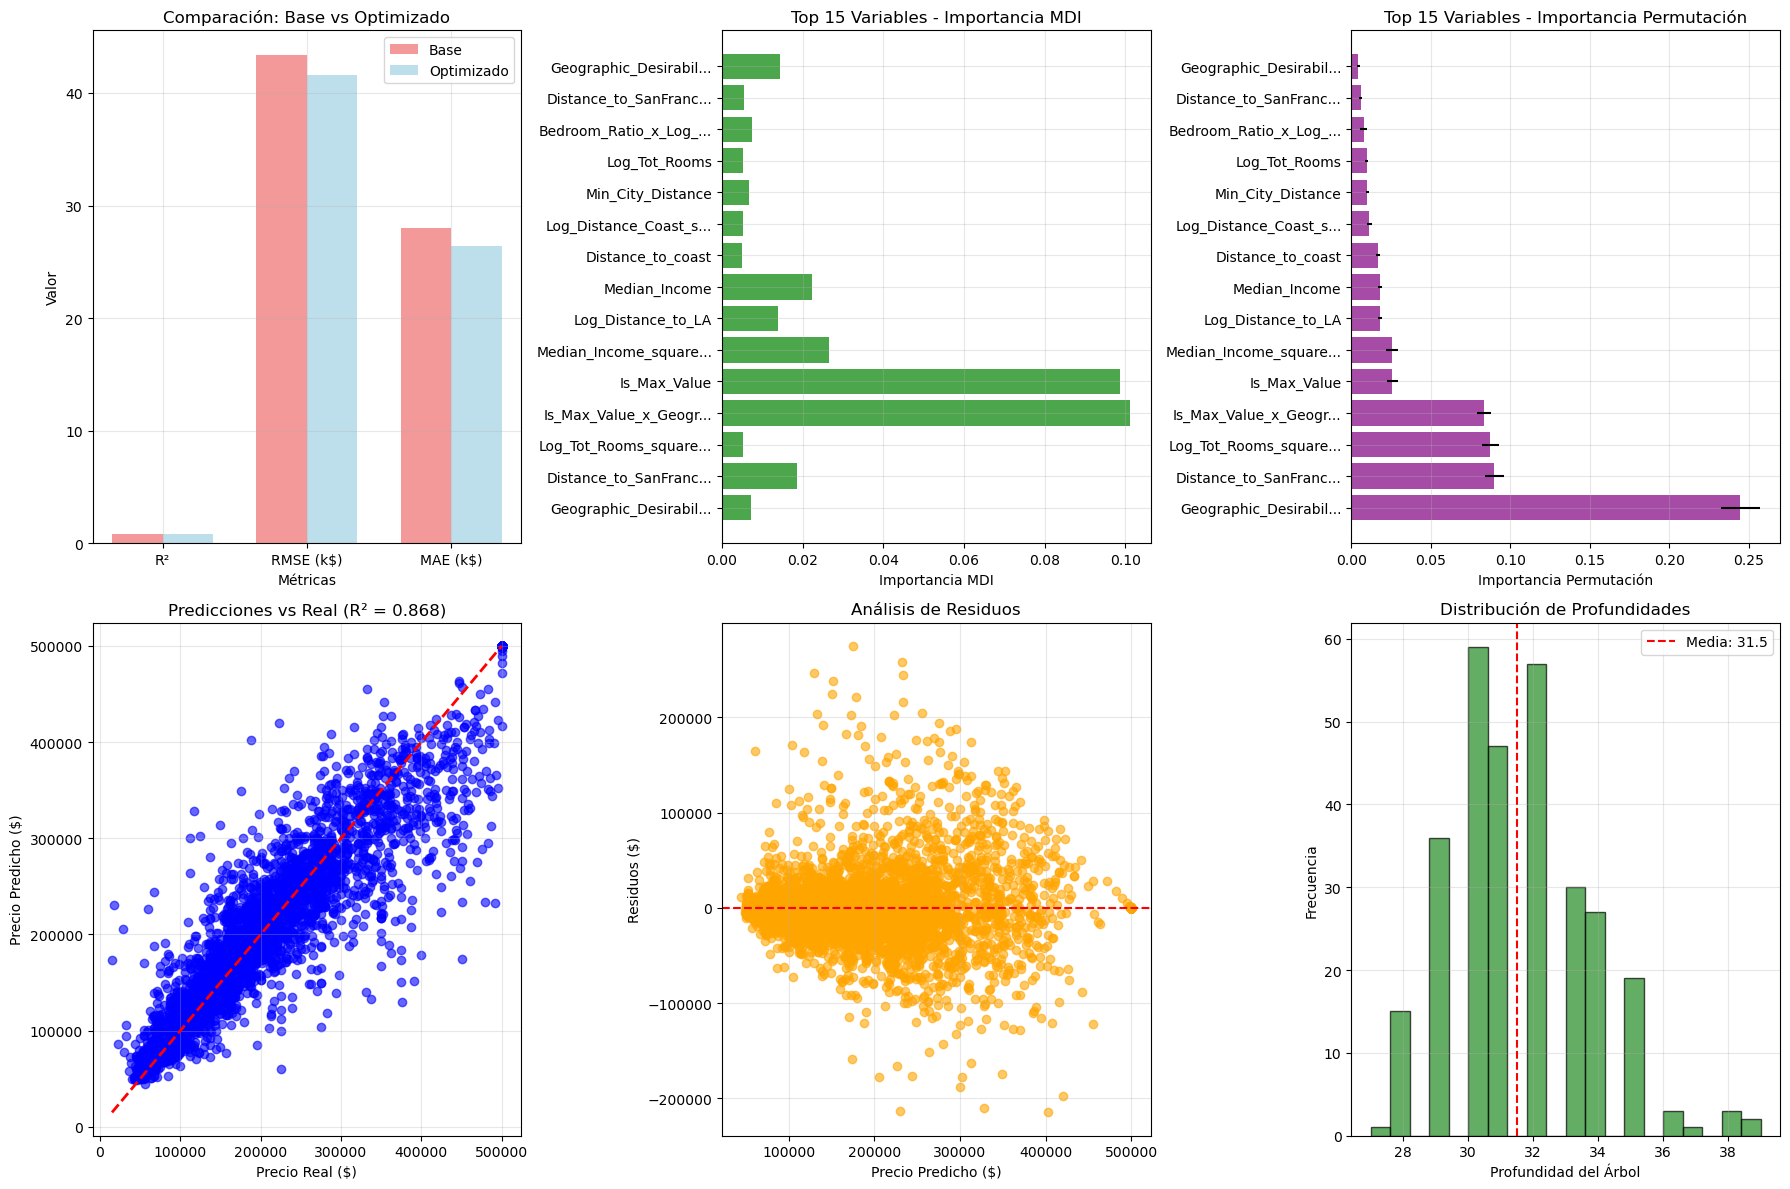

📈 ANÁLISIS DE RESIDUOS:
  Media: $372
  Std: $41,558
  MAE: $26,424
  % dentro de ±$50k: 85.5%
  % dentro de ±$100k: 95.9%

=== COMPARACIÓN MÉTODOS DE IMPORTANCIA ===

🤝 VARIABLES EN COMÚN (top 10): 4
  ✓ Is_Max_Value
  ✓ Is_Max_Value_x_Geographic_Desirability
  ✓ Median_Income
  ✓ Median_Income_squared

🟡 SOLO EN MDI: 6
  • Bedroom_Income_Ratio
  • Log_Distance_to_SanFrancisco
  • Log_Min_City_Distance_x_Log_Distance_Coast
  • Median_Income_cubed
  • Median_Income_x_Geographic_Desirability
  • Population_Density

🟣 SOLO EN PERMUTACIÓN: 6
  • Distance_to_SanFrancisco
  • Distance_to_coast
  • Geographic_Desirability_cubed
  • Log_Distance_Coast_squared
  • Log_Distance_to_LA
  • Log_Tot_Rooms_squared

📊 CORRELACIÓN ENTRE MÉTODOS: 0.009


In [137]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

def train_random_forest_model(data_dict, optimize_hyperparams=True, use_extra_trees=False):
    """
    Entrenar modelo Random Forest con optimización de hiperparámetros
    """
    print("=== ENTRENAMIENTO MODELO RANDOM FOREST ===\n")
    
    # Extraer datos
    X_train = data_dict['X_train']
    X_test = data_dict['X_test']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']
    
    print(f"📊 Datos de entrenamiento: {X_train.shape}")
    print(f"📊 Datos de prueba: {X_test.shape}")
    
    # Seleccionar tipo de modelo
    model_name = "Extra Trees" if use_extra_trees else "Random Forest"
    ModelClass = ExtraTreesRegressor if use_extra_trees else RandomForestRegressor
    
    print(f"🌲 Usando: {model_name}")
    
    # 1. MODELO BASE
    print(f"\n🔧 PASO 1: Entrenando modelo base...")
    
    # Configuración base
    base_params = {
        'n_estimators': 100,
        'random_state': 42,
        'n_jobs': -1,
        'warm_start': False
    }
    
    # Modelo base
    rf_base = ModelClass(**base_params)
    rf_base.fit(X_train, y_train)
    
    # Predicciones base
    y_pred_train_base = rf_base.predict(X_train)
    y_pred_test_base = rf_base.predict(X_test)
    
    # Métricas base
    base_metrics = {
        'train_r2': r2_score(y_train, y_pred_train_base),
        'test_r2': r2_score(y_test, y_pred_test_base),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train_base)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_base)),
        'train_mae': mean_absolute_error(y_train, y_pred_train_base),
        'test_mae': mean_absolute_error(y_test, y_pred_test_base)
    }
    
    print(f"  ✓ R² Test (base): {base_metrics['test_r2']:.4f}")
    print(f"  ✓ RMSE Test (base): ${base_metrics['test_rmse']:,.0f}")
    print(f"  ✓ MAE Test (base): ${base_metrics['test_mae']:,.0f}")
    
    # 2. OPTIMIZACIÓN DE HIPERPARÁMETROS
    best_model = rf_base
    optimized_metrics = base_metrics
    best_params = base_params.copy()
    
    if optimize_hyperparams:
        print(f"\n🎯 PASO 2: Optimizando hiperparámetros...")
        
        # Espacio de búsqueda
        param_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [10, 15, 20, 25, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', 0.5, 0.8],
            'bootstrap': [True, False] if not use_extra_trees else [True]  # Extra Trees siempre usa bootstrap=False por defecto
        }
        
        print("  🔍 Ejecutando búsqueda aleatoria...")
        
        rf_search = ModelClass(random_state=42, n_jobs=-1)
        
        random_search = RandomizedSearchCV(
            rf_search,
            param_distributions=param_grid,
            n_iter=30,  # 30 combinaciones aleatorias
            cv=3,       # 3-fold cross validation
            scoring='r2',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        random_search.fit(X_train, y_train)
        
        # Mejor modelo
        best_model = random_search.best_estimator_
        best_params.update(random_search.best_params_)
        
        print(f"  ✓ Mejor CV Score: {random_search.best_score_:.4f}")
        print(f"  ✓ Mejores parámetros encontrados:")
        for param, value in random_search.best_params_.items():
            print(f"    {param}: {value}")
        
        # Predicciones del modelo optimizado
        y_pred_train_opt = best_model.predict(X_train)
        y_pred_test_opt = best_model.predict(X_test)
        
        # Métricas optimizadas
        optimized_metrics = {
            'train_r2': r2_score(y_train, y_pred_train_opt),
            'test_r2': r2_score(y_test, y_pred_test_opt),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train_opt)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_opt)),
            'train_mae': mean_absolute_error(y_train, y_pred_train_opt),
            'test_mae': mean_absolute_error(y_test, y_pred_test_opt)
        }
        
        print(f"\n📈 MEJORA DESPUÉS DE OPTIMIZACIÓN:")
        print(f"  R² Test: {base_metrics['test_r2']:.4f} → {optimized_metrics['test_r2']:.4f} (+{optimized_metrics['test_r2']-base_metrics['test_r2']:.4f})")
        print(f"  RMSE Test: ${base_metrics['test_rmse']:,.0f} → ${optimized_metrics['test_rmse']:,.0f} ({optimized_metrics['test_rmse']-base_metrics['test_rmse']:+,.0f})")
    
    # 3. VALIDACIÓN CRUZADA
    print(f"\n🔄 PASO 3: Validación cruzada...")
    
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
    
    print(f"  ✓ CV R² Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  ✓ CV R² Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")
    
    # 4. ANÁLISIS DE IMPORTANCIA DE VARIABLES
    print(f"\n🎯 PASO 4: Análisis de importancia de variables...")
    
    # Importancia estándar (Gini/MDI)
    feature_importance = pd.DataFrame({
        'Feature': data_dict['feature_names'],
        'Importance_MDI': best_model.feature_importances_
    }).sort_values('Importance_MDI', ascending=False)
    
    print(f"  ✓ Top 10 variables más importantes (MDI):")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"    {i:2d}. {row['Feature']:<35s}: {row['Importance_MDI']:.4f}")
    
    # 5. IMPORTANCIA POR PERMUTACIÓN (más robusta)
    print(f"\n🔀 PASO 5: Calculando importancia por permutación...")
    
    # Usar submuestra para acelerar el cálculo
    sample_size = min(1000, len(X_test))
    sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
    X_test_sample = X_test.iloc[sample_indices]
    y_test_sample = y_test.iloc[sample_indices]
    
    perm_importance = permutation_importance(
        best_model, X_test_sample, y_test_sample,
        n_repeats=5, random_state=42, n_jobs=-1
    )
    
    # Añadir importancia por permutación al DataFrame
    feature_importance['Importance_Perm'] = perm_importance.importances_mean
    feature_importance['Importance_Perm_Std'] = perm_importance.importances_std
    
    # Reordenar por importancia de permutación
    feature_importance_perm = feature_importance.sort_values('Importance_Perm', ascending=False)
    
    print(f"  ✓ Top 10 variables más importantes (Permutación):")
    for i, (_, row) in enumerate(feature_importance_perm.head(10).iterrows(), 1):
        print(f"    {i:2d}. {row['Feature']:<35s}: {row['Importance_Perm']:.4f} ± {row['Importance_Perm_Std']:.4f}")
    
    # 6. ANÁLISIS DE ÁRBOLES
    print(f"\n🌳 PASO 6: Análisis de los árboles...")
    
    # Estadísticas de los árboles
    tree_depths = [tree.get_depth() for tree in best_model.estimators_]
    tree_leaves = [tree.get_n_leaves() for tree in best_model.estimators_]
    
    print(f"  ✓ Número de árboles: {best_model.n_estimators}")
    print(f"  ✓ Profundidad promedio: {np.mean(tree_depths):.1f} ± {np.std(tree_depths):.1f}")
    print(f"  ✓ Hojas promedio: {np.mean(tree_leaves):.1f} ± {np.std(tree_leaves):.1f}")
    print(f"  ✓ Profundidad máxima observada: {max(tree_depths)}")
    
    # 7. RESULTADOS FINALES
    print(f"\n📊 RESULTADOS FINALES {model_name.upper()}:")
    print(f"  🎯 R² Test: {optimized_metrics['test_r2']:.4f}")
    print(f"  📏 RMSE Test: ${optimized_metrics['test_rmse']:,.0f}")
    print(f"  📐 MAE Test: ${optimized_metrics['test_mae']:,.0f}")
    print(f"  🔧 Parámetros: {len(best_params)} configurados")
    print(f"  📈 Variables: {len(data_dict['feature_names'])}")
    
    # Retornar resultados completos
    return {
        'model': best_model,
        'base_model': rf_base,
        'model_type': model_name,
        'metrics': optimized_metrics,
        'base_metrics': base_metrics,
        'best_params': best_params,
        'feature_importance': feature_importance_perm,
        'cv_scores': cv_scores,
        'tree_stats': {
            'depths': tree_depths,
            'leaves': tree_leaves,
            'avg_depth': np.mean(tree_depths),
            'avg_leaves': np.mean(tree_leaves)
        },
        'predictions': {
            'y_train': y_train,
            'y_test': y_test,
            'y_pred_train': best_model.predict(X_train),
            'y_pred_test': best_model.predict(X_test)
        }
    }

def visualize_random_forest_results(rf_results):
    """
    Visualizar resultados del modelo Random Forest
    """
    print(f"\n=== VISUALIZACIÓN RESULTADOS {rf_results['model_type'].upper()} ===\n")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Comparación métricas base vs optimizado
    if 'base_metrics' in rf_results:
        metrics_comparison = pd.DataFrame({
            'Base': [rf_results['base_metrics']['test_r2'], 
                    rf_results['base_metrics']['test_rmse']/1000,  # En miles para visualización
                    rf_results['base_metrics']['test_mae']/1000],
            'Optimizado': [rf_results['metrics']['test_r2'],
                          rf_results['metrics']['test_rmse']/1000, 
                          rf_results['metrics']['test_mae']/1000],
            'Métrica': ['R²', 'RMSE (k$)', 'MAE (k$)']
        })
        
        x_pos = np.arange(len(metrics_comparison))
        width = 0.35
        
        axes[0,0].bar(x_pos - width/2, metrics_comparison['Base'], width, 
                     label='Base', alpha=0.8, color='lightcoral')
        axes[0,0].bar(x_pos + width/2, metrics_comparison['Optimizado'], width, 
                     label='Optimizado', alpha=0.8, color='lightblue')
        axes[0,0].set_xlabel('Métricas')
        axes[0,0].set_ylabel('Valor')
        axes[0,0].set_title('Comparación: Base vs Optimizado')
        axes[0,0].set_xticks(x_pos)
        axes[0,0].set_xticklabels(metrics_comparison['Métrica'])
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
    
    # 2. Importancia de variables (MDI)
    top_features_mdi = rf_results['feature_importance'].head(15)
    
    axes[0,1].barh(range(len(top_features_mdi)), top_features_mdi['Importance_MDI'], 
                   color='green', alpha=0.7)
    axes[0,1].set_yticks(range(len(top_features_mdi)))
    axes[0,1].set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_features_mdi['Feature']])
    axes[0,1].set_xlabel('Importancia MDI')
    axes[0,1].set_title('Top 15 Variables - Importancia MDI')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Importancia por permutación
    top_features_perm = rf_results['feature_importance'].head(15)
    
    axes[0,2].barh(range(len(top_features_perm)), top_features_perm['Importance_Perm'], 
                   xerr=top_features_perm['Importance_Perm_Std'],
                   color='purple', alpha=0.7)
    axes[0,2].set_yticks(range(len(top_features_perm)))
    axes[0,2].set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_features_perm['Feature']])
    axes[0,2].set_xlabel('Importancia Permutación')
    axes[0,2].set_title('Top 15 Variables - Importancia Permutación')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Predicciones vs Real
    predictions = rf_results['predictions']
    
    axes[1,0].scatter(predictions['y_test'], predictions['y_pred_test'], alpha=0.6, color='blue')
    axes[1,0].plot([predictions['y_test'].min(), predictions['y_test'].max()], 
                   [predictions['y_test'].min(), predictions['y_test'].max()], 'r--', lw=2)
    axes[1,0].set_xlabel('Precio Real ($)')
    axes[1,0].set_ylabel('Precio Predicho ($)')
    axes[1,0].set_title(f'Predicciones vs Real (R² = {rf_results["metrics"]["test_r2"]:.3f})')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Análisis de residuos
    residuos = predictions['y_test'] - predictions['y_pred_test']
    
    axes[1,1].scatter(predictions['y_pred_test'], residuos, alpha=0.6, color='orange')
    axes[1,1].axhline(y=0, color='r', linestyle='--')
    axes[1,1].set_xlabel('Precio Predicho ($)')
    axes[1,1].set_ylabel('Residuos ($)')
    axes[1,1].set_title('Análisis de Residuos')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Distribución de profundidades de árboles
    tree_depths = rf_results['tree_stats']['depths']
    
    axes[1,2].hist(tree_depths, bins=20, alpha=0.7, color='forestgreen', edgecolor='black')
    axes[1,2].axvline(np.mean(tree_depths), color='red', linestyle='--', 
                     label=f'Media: {np.mean(tree_depths):.1f}')
    axes[1,2].set_xlabel('Profundidad del Árbol')
    axes[1,2].set_ylabel('Frecuencia')
    axes[1,2].set_title('Distribución de Profundidades')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de residuos
    print(f"📈 ANÁLISIS DE RESIDUOS:")
    print(f"  Media: ${residuos.mean():,.0f}")
    print(f"  Std: ${residuos.std():,.0f}")
    print(f"  MAE: ${np.abs(residuos).mean():,.0f}")
    print(f"  % dentro de ±$50k: {(np.abs(residuos) <= 50000).mean()*100:.1f}%")
    print(f"  % dentro de ±$100k: {(np.abs(residuos) <= 100000).mean()*100:.1f}%")

def compare_importance_methods(rf_results):
    """
    Comparar métodos de importancia de variables
    """
    print(f"\n=== COMPARACIÓN MÉTODOS DE IMPORTANCIA ===\n")
    
    # Top 10 de cada método
    importance_df = rf_results['feature_importance']
    
    top_mdi = set(importance_df.nlargest(10, 'Importance_MDI')['Feature'])
    top_perm = set(importance_df.nlargest(10, 'Importance_Perm')['Feature'])
    
    # Variables en común
    common_vars = top_mdi.intersection(top_perm)
    mdi_only = top_mdi - top_perm
    perm_only = top_perm - top_mdi
    
    print(f"🤝 VARIABLES EN COMÚN (top 10): {len(common_vars)}")
    for var in sorted(common_vars):
        print(f"  ✓ {var}")
    
    print(f"\n🟡 SOLO EN MDI: {len(mdi_only)}")
    for var in sorted(mdi_only):
        print(f"  • {var}")
    
    print(f"\n🟣 SOLO EN PERMUTACIÓN: {len(perm_only)}")
    for var in sorted(perm_only):
        print(f"  • {var}")
    
    # Correlación entre métodos
    corr_methods = importance_df[['Importance_MDI', 'Importance_Perm']].corr().iloc[0,1]
    print(f"\n📊 CORRELACIÓN ENTRE MÉTODOS: {corr_methods:.3f}")

# Función principal para usar Random Forest
def run_random_forest_analysis(data_dict, optimize=True, use_extra_trees=False, visualize=True):
    """
    Función principal para ejecutar análisis completo con Random Forest
    """
    model_name = "Extra Trees" if use_extra_trees else "Random Forest"
    print(f"🚀 INICIANDO ANÁLISIS COMPLETO {model_name.upper()}...\n")
    
    # 1. Entrenar modelo
    rf_results = train_random_forest_model(data_dict, optimize_hyperparams=optimize, 
                                          use_extra_trees=use_extra_trees)
    
    # 2. Visualizar resultados
    if visualize:
        visualize_random_forest_results(rf_results)
    
    # 3. Comparar métodos de importancia
    compare_importance_methods(rf_results)
    
    return rf_results


rf_results = run_random_forest_analysis(data_dict, optimize=True, use_extra_trees=False)


## 4.3 lightgbm

✅ LightGBM disponible
🚀 INICIANDO ANÁLISIS COMPLETO LIGHTGBM...

=== ENTRENAMIENTO MODELO LIGHTGBM ===

📊 Datos de entrenamiento: (16512, 41)
📊 Datos de prueba: (4128, 41)

🔧 PASO 1: Entrenando modelo base...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 42601
  ✓ R² Test (base): 0.8615
  ✓ RMSE Test (base): $42,601
  ✓ MAE Test (base): $28,326
  ✓ Número de árboles: 100

🎯 PASO 2: Optimizando hiperparámetros...
  🔍 Ejecutando búsqueda aleatoria...
  ✓ Mejor CV Score: 0.8657
  ✓ Mejores parámetros encontrados:
    reg_lambda: 0.1
    reg_alpha: 0.5
    num_leaves: 63
    n_estimators: 200
    learning_rate: 0.05
    feature_fraction: 0.7
    bagging_freq: 3
    bagging_fraction: 0.9
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 40915.8

📈 MEJORA DESPUÉS DE OPTIMIZACIÓN:
  R² Test: 0.8615 → 0.8722 (+0.0107)
  RMSE Test:

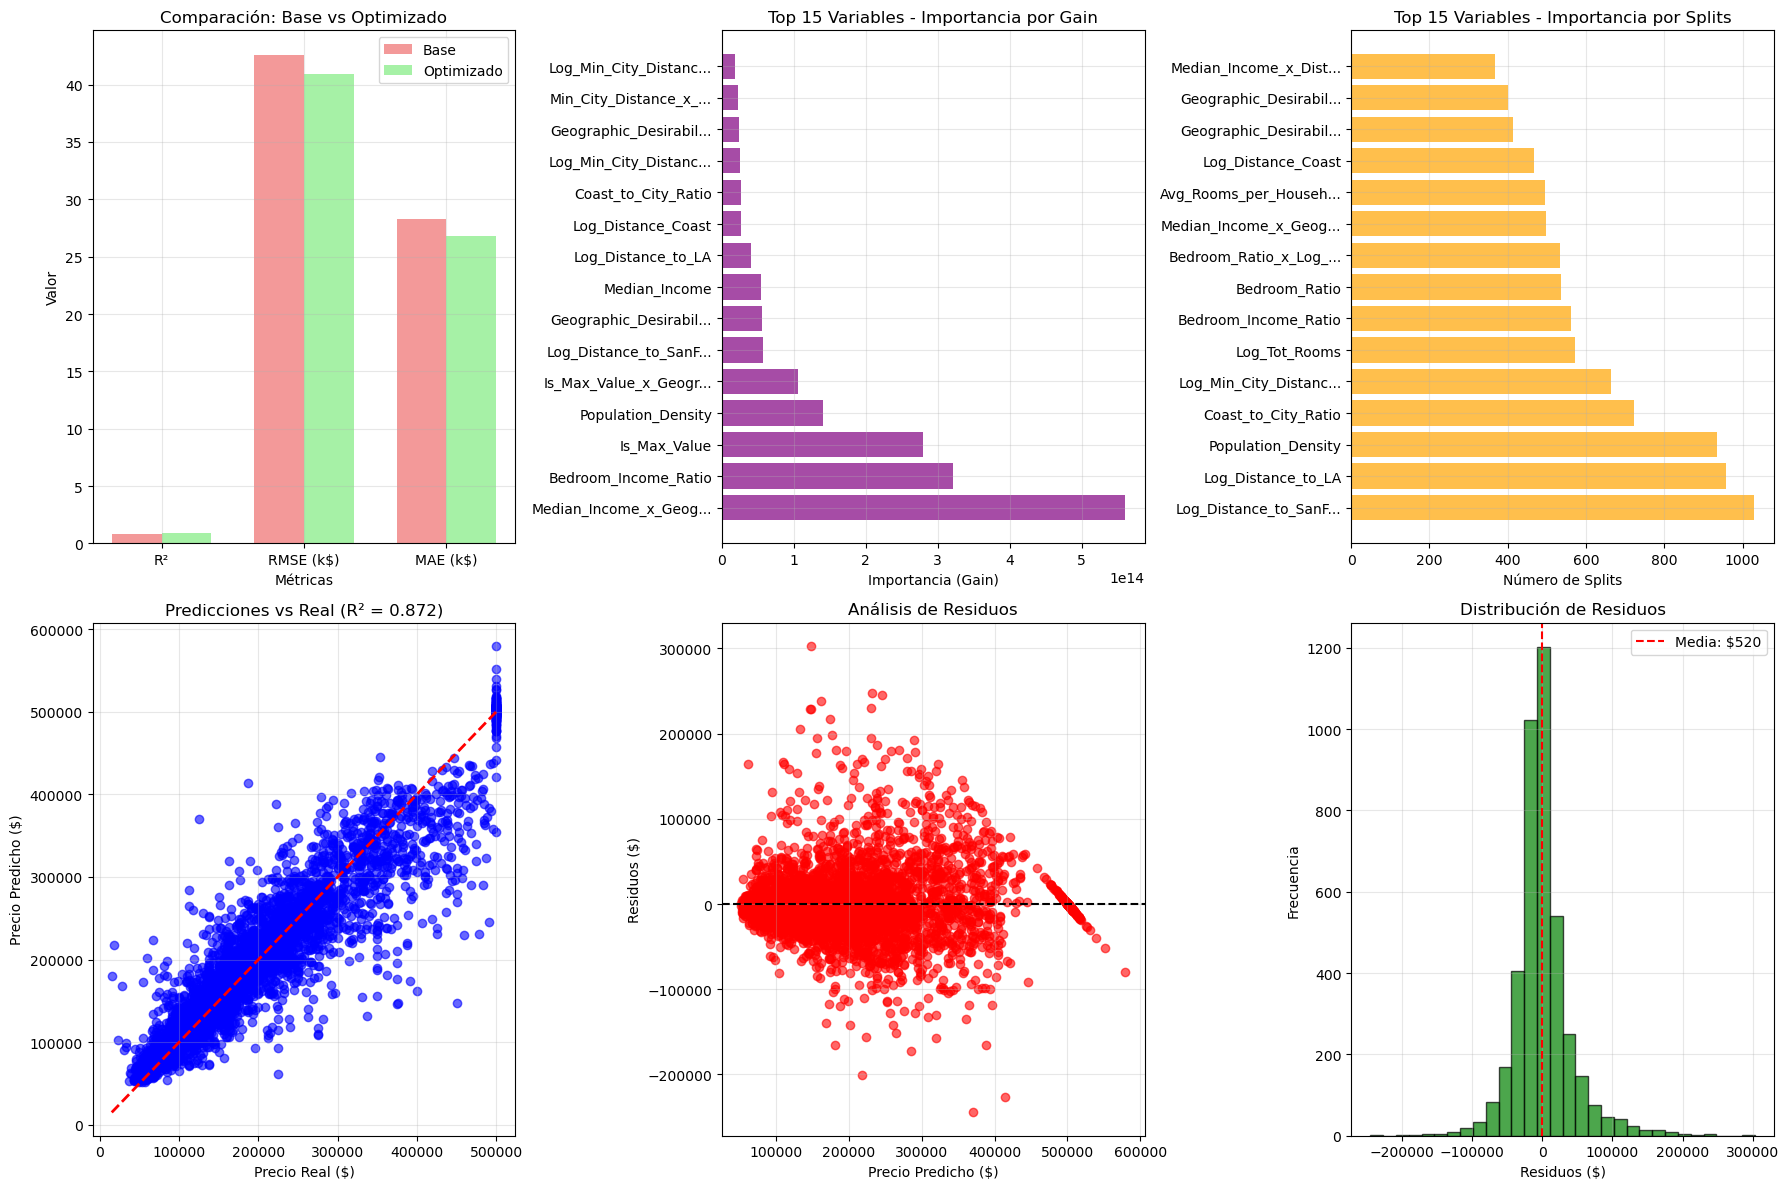

📈 ANÁLISIS DE RESIDUOS:
  Media: $520
  Std: $40,917
  MAE: $26,803
  % dentro de ±$50k: 85.3%
  % dentro de ±$100k: 96.4%

=== ANÁLISIS ESTRUCTURA DE ÁRBOLES ===

🌳 INFORMACIÓN BÁSICA:
  Número total de árboles: 200
  Número de características: 41
  Tipo de boosting: gbdt
  Objetivo: regression

📊 ANÁLISIS DE IMPORTANCIA:
  Variables con gain > 0: 40
  Variables con splits > 0: 40
  Top variable (gain): Median_Income_x_Geographic_Desirability (559595899686656)
  Top variable (splits): Log_Distance_to_SanFrancisco (1029)


In [141]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Importar LightGBM
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✅ LightGBM disponible")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("❌ LightGBM no instalado. Ejecutar: pip install lightgbm")

def train_lightgbm_model(data_dict, optimize_hyperparams=True, use_gpu=False):
    """
    Entrenar modelo LightGBM con optimización de hiperparámetros
    """
    if not LIGHTGBM_AVAILABLE:
        print("❌ LightGBM no está disponible. Instalar con: pip install lightgbm")
        return None
    
    print("=== ENTRENAMIENTO MODELO LIGHTGBM ===\n")
    
    # Extraer datos
    X_train = data_dict['X_train']
    X_test = data_dict['X_test']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']
    
    print(f"📊 Datos de entrenamiento: {X_train.shape}")
    print(f"📊 Datos de prueba: {X_test.shape}")
    
    # 1. MODELO BASE
    print(f"\n🔧 PASO 1: Entrenando modelo base...")
    
    # Configuración base
    base_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1  # Silenciar output
    }
    
    # Configuración GPU si está disponible
    if use_gpu:
        try:
            base_params['device'] = 'gpu'
            base_params['gpu_platform_id'] = 0
            base_params['gpu_device_id'] = 0
            print("🚀 Usando GPU para entrenamiento")
        except:
            print("⚠️ GPU no disponible, usando CPU")
    
    # Crear datasets de LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Entrenar modelo base
    lgb_base = lgb.train(
        params=base_params,
        train_set=train_data,
        num_boost_round=100,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
    )
    
    # Predicciones base
    y_pred_train_base = lgb_base.predict(X_train)
    y_pred_test_base = lgb_base.predict(X_test)
    
    # Métricas base
    base_metrics = {
        'train_r2': r2_score(y_train, y_pred_train_base),
        'test_r2': r2_score(y_test, y_pred_test_base),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train_base)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_base)),
        'train_mae': mean_absolute_error(y_train, y_pred_train_base),
        'test_mae': mean_absolute_error(y_test, y_pred_test_base)
    }
    
    print(f"  ✓ R² Test (base): {base_metrics['test_r2']:.4f}")
    print(f"  ✓ RMSE Test (base): ${base_metrics['test_rmse']:,.0f}")
    print(f"  ✓ MAE Test (base): ${base_metrics['test_mae']:,.0f}")
    print(f"  ✓ Número de árboles: {lgb_base.num_trees()}")
    
    # 2. OPTIMIZACIÓN DE HIPERPARÁMETROS
    best_model = lgb_base
    optimized_metrics = base_metrics
    best_params = base_params.copy()
    
    if optimize_hyperparams:
        print(f"\n🎯 PASO 2: Optimizando hiperparámetros...")
        
        # Usar el wrapper de sklearn para facilitar la búsqueda
        lgb_regressor = lgb.LGBMRegressor(
            objective='regression',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        
        # Espacio de búsqueda (eliminando parámetros problemáticos)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'num_leaves': [15, 31, 63],
            'learning_rate': [0.05, 0.1, 0.15],
            'feature_fraction': [0.7, 0.8, 0.9],
            'bagging_fraction': [0.7, 0.8, 0.9],
            'bagging_freq': [3, 5, 7],
            'reg_alpha': [0, 0.1, 0.5],
            'reg_lambda': [0, 0.1, 0.5]
        }
        
        print("  🔍 Ejecutando búsqueda aleatoria...")
        
        random_search = RandomizedSearchCV(
            lgb_regressor,
            param_distributions=param_grid,
            n_iter=40,  # 40 combinaciones aleatorias
            cv=3,       # 3-fold cross validation
            scoring='r2',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        random_search.fit(X_train, y_train)
        
        # Mejor modelo
        best_model_sklearn = random_search.best_estimator_
        best_params.update(random_search.best_params_)
        
        print(f"  ✓ Mejor CV Score: {random_search.best_score_:.4f}")
        print(f"  ✓ Mejores parámetros encontrados:")
        for param, value in random_search.best_params_.items():
            print(f"    {param}: {value}")
        
        # Reentrenar con parámetros óptimos usando API nativa
        optimized_params = base_params.copy()
        best_params_copy = random_search.best_params_.copy()
        
        # Solo mapear el parámetro n_estimators, el resto mantenerlos como están
        num_boost_round = best_params_copy.pop('n_estimators', 200)
        
        # Añadir parámetros optimizados (excluyendo n_estimators)
        for param, value in best_params_copy.items():
            optimized_params[param] = value
        
        # Añadir configuración para evitar conflictos
        optimized_params['feature_pre_filter'] = False
        
        # Recrear datasets para evitar problemas de estado
        train_data_opt = lgb.Dataset(X_train, label=y_train)
        valid_data_opt = lgb.Dataset(X_test, label=y_test, reference=train_data_opt)
        
        best_model = lgb.train(
            params=optimized_params,
            train_set=train_data_opt,
            num_boost_round=num_boost_round,
            valid_sets=[valid_data_opt],
            callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]
        )
        
        # Predicciones del modelo optimizado
        y_pred_train_opt = best_model.predict(X_train)
        y_pred_test_opt = best_model.predict(X_test)
        
        # Métricas optimizadas
        optimized_metrics = {
            'train_r2': r2_score(y_train, y_pred_train_opt),
            'test_r2': r2_score(y_test, y_pred_test_opt),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train_opt)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_opt)),
            'train_mae': mean_absolute_error(y_train, y_pred_train_opt),
            'test_mae': mean_absolute_error(y_test, y_pred_test_opt)
        }
        
        print(f"\n📈 MEJORA DESPUÉS DE OPTIMIZACIÓN:")
        print(f"  R² Test: {base_metrics['test_r2']:.4f} → {optimized_metrics['test_r2']:.4f} (+{optimized_metrics['test_r2']-base_metrics['test_r2']:.4f})")
        print(f"  RMSE Test: ${base_metrics['test_rmse']:,.0f} → ${optimized_metrics['test_rmse']:,.0f} ({optimized_metrics['test_rmse']-base_metrics['test_rmse']:+,.0f})")
        print(f"  Número de árboles: {lgb_base.num_trees()} → {best_model.num_trees()}")
    
    # 3. VALIDACIÓN CRUZADA CON SKLEARN WRAPPER
    print(f"\n🔄 PASO 3: Validación cruzada...")
    
    # Usar el mejor modelo sklearn para CV
    if optimize_hyperparams:
        cv_model = best_model_sklearn
    else:
        cv_model = lgb.LGBMRegressor(**base_params)
        cv_model.fit(X_train, y_train)
    
    cv_scores = cross_val_score(cv_model, X_train, y_train, cv=5, scoring='r2')
    
    print(f"  ✓ CV R² Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  ✓ CV R² Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")
    
    # 4. ANÁLISIS DE IMPORTANCIA DE VARIABLES
    print(f"\n🎯 PASO 4: Análisis de importancia de variables...")
    
    # Obtener importancias del modelo nativo LightGBM
    feature_importance = pd.DataFrame({
        'Feature': data_dict['feature_names'],
        'Importance_Gain': best_model.feature_importance(importance_type='gain'),
        'Importance_Split': best_model.feature_importance(importance_type='split')
    })
    
    # Ordenar por gain (más informativo)
    feature_importance = feature_importance.sort_values('Importance_Gain', ascending=False)
    
    print(f"  ✓ Top 10 variables más importantes (Gain):")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"    {i:2d}. {row['Feature']:<35s}: {row['Importance_Gain']:8.0f} (splits: {row['Importance_Split']:4.0f})")
    
    # 5. ANÁLISIS DE CONVERGENCIA
    print(f"\n📈 PASO 5: Análisis de convergencia...")
    
    # Obtener histórico de validación
    eval_results = best_model.eval_valid()
    if eval_results:
        best_iteration = best_model.best_iteration
        best_score = best_model.best_score['valid_0']['rmse']
        total_iterations = len(eval_results[0]['rmse'])
        
        print(f"  ✓ Mejor iteración: {best_iteration}/{total_iterations}")
        print(f"  ✓ Mejor RMSE validación: ${best_score:,.0f}")
        print(f"  ✓ Early stopping activado: {best_iteration < total_iterations}")
    
    # 6. RESULTADOS FINALES
    print(f"\n📊 RESULTADOS FINALES LIGHTGBM:")
    print(f"  🎯 R² Test: {optimized_metrics['test_r2']:.4f}")
    print(f"  📏 RMSE Test: ${optimized_metrics['test_rmse']:,.0f}")
    print(f"  📐 MAE Test: ${optimized_metrics['test_mae']:,.0f}")
    print(f"  🌳 Número de árboles: {best_model.num_trees()}")
    print(f"  🔧 Parámetros: {len(best_params)} configurados")
    print(f"  📈 Variables: {len(data_dict['feature_names'])}")
    
    # Retornar resultados completos
    return {
        'model': best_model,
        'base_model': lgb_base,
        'sklearn_model': best_model_sklearn if optimize_hyperparams else None,
        'metrics': optimized_metrics,
        'base_metrics': base_metrics,
        'best_params': best_params,
        'feature_importance': feature_importance,
        'cv_scores': cv_scores,
        'eval_history': eval_results if 'eval_results' in locals() else None,
        'predictions': {
            'y_train': y_train,
            'y_test': y_test,
            'y_pred_train': best_model.predict(X_train),
            'y_pred_test': best_model.predict(X_test)
        }
    }

def visualize_lightgbm_results(lgb_results):
    """
    Visualizar resultados del modelo LightGBM
    """
    print("\n=== VISUALIZACIÓN RESULTADOS LIGHTGBM ===\n")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Comparación métricas base vs optimizado
    if 'base_metrics' in lgb_results:
        metrics_comparison = pd.DataFrame({
            'Base': [lgb_results['base_metrics']['test_r2'], 
                    lgb_results['base_metrics']['test_rmse']/1000,
                    lgb_results['base_metrics']['test_mae']/1000],
            'Optimizado': [lgb_results['metrics']['test_r2'],
                          lgb_results['metrics']['test_rmse']/1000, 
                          lgb_results['metrics']['test_mae']/1000],
            'Métrica': ['R²', 'RMSE (k$)', 'MAE (k$)']
        })
        
        x_pos = np.arange(len(metrics_comparison))
        width = 0.35
        
        axes[0,0].bar(x_pos - width/2, metrics_comparison['Base'], width, 
                     label='Base', alpha=0.8, color='lightcoral')
        axes[0,0].bar(x_pos + width/2, metrics_comparison['Optimizado'], width, 
                     label='Optimizado', alpha=0.8, color='lightgreen')
        axes[0,0].set_xlabel('Métricas')
        axes[0,0].set_ylabel('Valor')
        axes[0,0].set_title('Comparación: Base vs Optimizado')
        axes[0,0].set_xticks(x_pos)
        axes[0,0].set_xticklabels(metrics_comparison['Métrica'])
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
    
    # 2. Importancia de variables (Gain)
    top_features_gain = lgb_results['feature_importance'].head(15)
    
    axes[0,1].barh(range(len(top_features_gain)), top_features_gain['Importance_Gain'], 
                   color='purple', alpha=0.7)
    axes[0,1].set_yticks(range(len(top_features_gain)))
    axes[0,1].set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_features_gain['Feature']])
    axes[0,1].set_xlabel('Importancia (Gain)')
    axes[0,1].set_title('Top 15 Variables - Importancia por Gain')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Importancia por número de splits
    top_features_split = lgb_results['feature_importance'].nlargest(15, 'Importance_Split')
    
    axes[0,2].barh(range(len(top_features_split)), top_features_split['Importance_Split'], 
                   color='orange', alpha=0.7)
    axes[0,2].set_yticks(range(len(top_features_split)))
    axes[0,2].set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_features_split['Feature']])
    axes[0,2].set_xlabel('Número de Splits')
    axes[0,2].set_title('Top 15 Variables - Importancia por Splits')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Predicciones vs Real
    predictions = lgb_results['predictions']
    
    axes[1,0].scatter(predictions['y_test'], predictions['y_pred_test'], alpha=0.6, color='blue')
    axes[1,0].plot([predictions['y_test'].min(), predictions['y_test'].max()], 
                   [predictions['y_test'].min(), predictions['y_test'].max()], 'r--', lw=2)
    axes[1,0].set_xlabel('Precio Real ($)')
    axes[1,0].set_ylabel('Precio Predicho ($)')
    axes[1,0].set_title(f'Predicciones vs Real (R² = {lgb_results["metrics"]["test_r2"]:.3f})')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Análisis de residuos
    residuos = predictions['y_test'] - predictions['y_pred_test']
    
    axes[1,1].scatter(predictions['y_pred_test'], residuos, alpha=0.6, color='red')
    axes[1,1].axhline(y=0, color='black', linestyle='--')
    axes[1,1].set_xlabel('Precio Predicho ($)')
    axes[1,1].set_ylabel('Residuos ($)')
    axes[1,1].set_title('Análisis de Residuos')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Convergencia del entrenamiento (si disponible)
    if lgb_results['eval_history']:
        eval_data = lgb_results['eval_history'][0]['rmse']
        iterations = range(1, len(eval_data) + 1)
        
        axes[1,2].plot(iterations, eval_data, 'b-', linewidth=2, label='Validación RMSE')
        
        # Marcar mejor iteración si está disponible
        best_iter = lgb_results['model'].best_iteration
        if best_iter and best_iter < len(eval_data):
            axes[1,2].axvline(x=best_iter, color='red', linestyle='--', 
                             label=f'Mejor iter: {best_iter}')
        
        axes[1,2].set_xlabel('Iteración')
        axes[1,2].set_ylabel('RMSE Validación')
        axes[1,2].set_title('Convergencia del Entrenamiento')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
    else:
        # Si no hay datos de convergencia, mostrar distribución de residuos
        axes[1,2].hist(residuos, bins=30, alpha=0.7, color='green', edgecolor='black')
        axes[1,2].axvline(residuos.mean(), color='red', linestyle='--', 
                         label=f'Media: ${residuos.mean():,.0f}')
        axes[1,2].set_xlabel('Residuos ($)')
        axes[1,2].set_ylabel('Frecuencia')
        axes[1,2].set_title('Distribución de Residuos')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de residuos
    print(f"📈 ANÁLISIS DE RESIDUOS:")
    print(f"  Media: ${residuos.mean():,.0f}")
    print(f"  Std: ${residuos.std():,.0f}")
    print(f"  MAE: ${np.abs(residuos).mean():,.0f}")
    print(f"  % dentro de ±$50k: {(np.abs(residuos) <= 50000).mean()*100:.1f}%")
    print(f"  % dentro de ±$100k: {(np.abs(residuos) <= 100000).mean()*100:.1f}%")

def analyze_lightgbm_tree_structure(lgb_results):
    """
    Analizar la estructura de los árboles en LightGBM
    """
    print("\n=== ANÁLISIS ESTRUCTURA DE ÁRBOLES ===\n")
    
    model = lgb_results['model']
    
    # Información básica
    num_trees = model.num_trees()
    num_features = model.num_feature()
    
    print(f"🌳 INFORMACIÓN BÁSICA:")
    print(f"  Número total de árboles: {num_trees}")
    print(f"  Número de características: {num_features}")
    print(f"  Tipo de boosting: {model.params.get('boosting_type', 'gbdt')}")
    print(f"  Objetivo: {model.params.get('objective', 'regression')}")
    
    # Estadísticas de hojas
    if hasattr(model, 'num_leaves'):
        print(f"  Número de hojas por árbol: {model.params.get('num_leaves', 'N/A')}")
    
    # Análisis de importancia por tipo
    feature_importance = lgb_results['feature_importance']
    
    print(f"\n📊 ANÁLISIS DE IMPORTANCIA:")
    print(f"  Variables con gain > 0: {(feature_importance['Importance_Gain'] > 0).sum()}")
    print(f"  Variables con splits > 0: {(feature_importance['Importance_Split'] > 0).sum()}")
    print(f"  Top variable (gain): {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Importance_Gain']:.0f})")
    print(f"  Top variable (splits): {feature_importance.nlargest(1, 'Importance_Split').iloc[0]['Feature']} ({feature_importance.nlargest(1, 'Importance_Split').iloc[0]['Importance_Split']:.0f})")

def save_lightgbm_model(lgb_results, filepath='lightgbm_model.txt'):
    """
    Guardar modelo LightGBM entrenado
    """
    if lgb_results and 'model' in lgb_results:
        try:
            lgb_results['model'].save_model(filepath)
            print(f"✅ Modelo LightGBM guardado en: {filepath}")
            
            # Guardar también métricas
            metrics_df = pd.DataFrame([lgb_results['metrics']])
            metrics_df.to_csv(filepath.replace('.txt', '_metrics.csv'), index=False)
            print(f"✅ Métricas guardadas en: {filepath.replace('.txt', '_metrics.csv')}")
            
            # Guardar importancia de variables
            lgb_results['feature_importance'].to_csv(
                filepath.replace('.txt', '_feature_importance.csv'), index=False
            )
            print(f"✅ Importancia guardada en: {filepath.replace('.txt', '_feature_importance.csv')}")
            
        except Exception as e:
            print(f"❌ Error guardando modelo: {e}")
    else:
        print("❌ No hay modelo para guardar")

# Función principal para usar LightGBM
def run_lightgbm_analysis(data_dict, optimize=True, visualize=True, save_model=False):
    """
    Función principal para ejecutar análisis completo con LightGBM
    """
    print("🚀 INICIANDO ANÁLISIS COMPLETO LIGHTGBM...\n")
    
    # 1. Entrenar modelo
    lgb_results = train_lightgbm_model(data_dict, optimize_hyperparams=optimize)
    
    if lgb_results is None:
        return None
    
    # 2. Visualizar resultados
    if visualize:
        visualize_lightgbm_results(lgb_results)
    
    # 3. Analizar estructura de árboles
    analyze_lightgbm_tree_structure(lgb_results)
    
    # 4. Guardar modelo si se solicita
    if save_model:
        save_lightgbm_model(lgb_results)
    
    return lgb_results

# Ejemplo de uso:
lgb_results = run_lightgbm_analysis(data_dict, optimize=True, visualize=True)

# **5. Evaluación y Selección del Modelo**


---

In [143]:
print("Comparación Final:")
print(f"XGBoost RMSE: {xgb_results['metrics']['test_rmse']:.4f}")
print(f"Random Forest RMSE: {rf_results['metrics']['test_rmse']:.4f}")
print(f"LightGBM RMSE: {lgb_results['metrics']['test_rmse']:.4f}")

Comparación Final:
XGBoost RMSE: 41503.1826
Random Forest RMSE: 41554.2846
LightGBM RMSE: 40915.7705
